## pyrodigal-rv versus pyrodigal-gv for finding ribosomal binding sites

One common use of pyrodigal-gv is to identiy ribosomal binding sites and subsequently classifying viruses (as is done in [this](https://www.nature.com/articles/s41586-020-1957-x) paper). Detection of these motifs via pyrodigal is also used in [genomad](https://github.com/apcamargo/genomad). 

In [4]:
# imports 
import polars as pl
import gzip 
import shutil 
import pathlib
import requests 
from tqdm import tqdm
from Bio import SeqIO
import re 
from typing import List, Dict, Any
import pyrodigal_gv
import pyrodigal_rv 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotnine import (
    ggplot, aes, geom_boxplot, facet_wrap, 
    labs, theme_minimal, theme, element_text, 
    scale_fill_manual, scale_color_manual, position_dodge
)

## 1. Dataset of Prokaryotic and Eukaryotic RNA Viruses 

In [7]:
# use refseq viruses and virhostdb to get viruses with known eukaryotic/prokaryotic hosts 
VIRHOSTDB_URL = "https://www.genome.jp/ftp/db/virushostdb/virushostdb.genomic.fna.gz"
VIRHOSTDB_OUT_GZ = pathlib.Path("virushostdb.genomic.fna.gz")

# 1. Download the gz file with a progress bar
with requests.get(VIRHOSTDB_URL, stream=True) as r:
    r.raise_for_status()
    # Get the total file size from the header
    total_size = int(r.headers.get("content-length", 0)) 
    chunk_size = 8192

    # Use tqdm to wrap the file writing loop
    with VIRHOSTDB_OUT_GZ.open("wb") as f, tqdm(
        desc=f"Downloading {VIRHOSTDB_OUT_GZ.name}",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            bar.update(len(chunk)) # Update the bar with the size of the written chunk
            
print("Download Complete.")

# 2. Unzip the file 
with gzip.open(VIRHOSTDB_OUT_GZ, 'rb') as f_in:
    with open(VIRHOSTDB_OUT_GZ.with_suffix(''), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out) 
        
print("Unzipping Complete.")

# 3. Read in the data 
virdhostdb_sequences = SeqIO.to_dict(SeqIO.parse(VIRHOSTDB_OUT_GZ.with_suffix(''), 'fasta'))
print("Data Loading Complete.")

Download Complete.
Unzipping Complete.
Unzipping Complete.
Data Loading Complete.
Data Loading Complete.


In [8]:
# use rvmt sequences as well 
RVMT_URL = "https://portal.nersc.gov/dna/microbial/prokpubs/Riboviria/RiboV1.4/RiboV1.4_Contigs.fasta.gz"
RVMT_OUT_GZ = pathlib.Path("RiboV1.4_Contigs.fasta.gz")

# 1. Download the gz file with a progress bar
with requests.get(RVMT_URL, stream=True) as r:
    r.raise_for_status()
    # Get the total file size from the header
    total_size = int(r.headers.get("content-length", 0)) 
    chunk_size = 8192

    # Use tqdm to wrap the file writing loop
    with RVMT_OUT_GZ.open("wb") as f, tqdm(
        desc=f"Downloading {RVMT_OUT_GZ.name}",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            bar.update(len(chunk)) # Update the bar with the size of the written chunk
            
print("Download Complete.")

# 2. Unzip the file 
with gzip.open(RVMT_OUT_GZ, 'rb') as f_in:
    with open(RVMT_OUT_GZ.with_suffix(''), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out) 
        
print("Unzipping Complete.")

# 3. Read in the data 
rvmt_sequences = SeqIO.to_dict(SeqIO.parse(RVMT_OUT_GZ.with_suffix(''), 'fasta'))
print("Data Loading Complete.")

Download Complete.
Unzipping Complete.
Unzipping Complete.
Data Loading Complete.
Data Loading Complete.


In [9]:
# read in the host info file 
virhostdb_details = pl.read_csv('https://www.genome.jp/ftp/db/virushostdb/virushostdb.tsv', separator="\t", has_header=True) # how good is polars! 

In [10]:
# filter to just the ones that are RNA viruses and either eukaryotic or bacterial hosts
virhostdb_euk_details = virhostdb_details.filter(pl.col('virus lineage').str.contains('Riboviria')).filter(pl.col('host lineage').str.contains('Eukaryota'))
virhostdb_bac_details = virhostdb_details.filter(pl.col('virus lineage').str.contains('Riboviria')).filter(pl.col('host lineage').str.contains('Bacteria'))

# flatten entries with multiple refseq ids into multiple rows 
virhostdb_bac_details = (
    virhostdb_bac_details
    .with_columns(
        # Use .str.split(delimiter) to convert the str column into a List[str] column
        pl.col("refseq id").str.split(',').alias("refseq_id_list")
    )
    .explode("refseq_id_list")
    # Clean up: remove the original 'refseq id' column and rename the new one
    .drop("refseq id")
    .rename({"refseq_id_list": "refseq id"})
)
virhostdb_euk_details = (
    virhostdb_euk_details
    .with_columns(
        # Use .str.split(delimiter) to convert the str column into a List[str] column
        pl.col("refseq id").str.split(',').alias("refseq_id_list")
    )
    .explode("refseq_id_list")
    # Clean up: remove the original 'refseq id' column and rename the new one
    .drop("refseq id")
    .rename({"refseq_id_list": "refseq id"})
)

virhostdb_euk_ids = virhostdb_euk_details['refseq id'].to_list()
virhostdb_bac_ids = virhostdb_bac_details['refseq id'].to_list()

# get the sequences for these viruses from the virdhostdb sequences
virhostdb_euk_sequences = {seq_id: virdhostdb_sequences[seq_id] for seq_id in virhostdb_euk_ids if seq_id in virdhostdb_sequences}
virhostdb_bac_sequences = {seq_id: virdhostdb_sequences[seq_id] for seq_id in virhostdb_bac_ids if seq_id in virdhostdb_sequences}


In [11]:
# supplement with additional sequences from rvmt databases becuase there are few prokarytoic RNA viruses in virhostdb
rvmt = pl.read_csv("https://portal.nersc.gov/dna/microbial/prokpubs/Riboviria/RiboV1.4/RiboV1.6_Info.tsv", separator="\t") # polars! 

# add a host domain column 
rvmt = rvmt.with_columns(
    pl.col("Host").str.split_exact(";", 1).struct["field_0"].alias("Host_domain")
) 

# see what is used as host evidence here 
print(rvmt['Host_Evidence'].value_counts())

# further inspect host evidence for bacteria - what seems reliable? 
# inspect the CRISPR spacer 
print('CRISPR spacer match counts by family:')
print(rvmt.filter(pl.col('Host_domain') == 'Bacteria').filter(pl.col('Host_Evidence') == 'Putative CRISPR spacer match')['Family'].value_counts())
# just partitiviruses - thought to infect eukaryotes - not defintively bacterial host  

# do the same for virhostdb
print('VirHostDB match counts by family:')
print(rvmt.filter(pl.col('Host_domain') == 'Bacteria').filter(pl.col('Host_Evidence') == 'virushostdb')['Family'].value_counts())

# do the same for bacteriolytic proteins 
print('Bacteriolytic protein counts by family:')
print(rvmt.filter(pl.col('Host_domain') == 'Bacteria').filter(pl.col('Host_Evidence') == 'Putative Host related domain - bacteriolytic protein')['Family'].value_counts())
# this shows a few groups that are sketchy as to whether they are phage - e.g picobirnaviridae, Narnaviridae (infect eukaryotes) - don't consider these because not super accepted 

# do the same for levivruses
print('Levivirus counts by family:')
print(rvmt.filter(pl.col('Host_domain') == 'Bacteria').filter(pl.col('Host_Evidence') == 'Host known clade - Leviviricetes OR Cystoviridae and putative CRISPR spacer match')['Family'].value_counts())
# Generally accepted - consider these  

# do the same for leviviricetes (is a class)
print('Levivirus counts by family:')
print(rvmt.filter(pl.col('Host_domain') == 'Bacteria').filter(pl.col('Host_Evidence') == 'Host known clade - Leviviricetes OR Cystoviridae')['Family'].value_counts().sort('count'))
# also consider these 

# also look at host evidence for eukaryotes 
print(rvmt.filter(pl.col('Host_domain') == 'Eukaryota')['Host_Evidence'].value_counts()) 

# check the family distribution for ones identified with movement proteins 
print(rvmt.filter(pl.col('Host_domain') == 'Eukaryota').filter(pl.col('Host_Evidence') == 'Host related domain - Movement protein')['Family'].value_counts())

shape: (10, 2)
┌─────────────────────────────────┬────────┐
│ Host_Evidence                   ┆ count  │
│ ---                             ┆ ---    │
│ str                             ┆ u32    │
╞═════════════════════════════════╪════════╡
│ Putative CRISPR spacer match    ┆ 154    │
│ Putative Host related domain -… ┆ 332    │
│ Host known clade - Leviviricet… ┆ 7      │
│ null                            ┆ 306221 │
│ Host related domain - Movement… ┆ 1807   │
│ PMID:12777056                   ┆ 1      │
│ Host known clade - Leviviricet… ┆ 66273  │
│ virushostdb                     ┆ 3610   │
│ MMETSP Host genetic code match… ┆ 2      │
│ PMID:9526504, PMID:24999047     ┆ 2      │
└─────────────────────────────────┴────────┘
CRISPR spacer match counts by family:
shape: (1, 2)
┌────────────────┬───────┐
│ Family         ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ Partitiviridae ┆ 154   │
└────────────────┴───────┘
VirHostDB match counts b

In [12]:
# put all of these sequences together 
search_list = [
    'virushostdb', 
    'Host known clade - Leviviricetes OR Cystoviridae', 
    'Host related domain - Movement protein'
]

# Command to filter the DataFrame 'rvmt' based on the desired 'Host_Evidence' values
filtered_rvmt = rvmt.filter(
    pl.col('Host_Evidence').is_in(search_list)
)

# further filter to remove viruses that infect other viruses(??) 
filtered_rvmt = filtered_rvmt.filter(pl.col('Host_domain') != 'Viruses')

# get the ids and sequences
rvmt_bac_ids = filtered_rvmt.filter(pl.col('Host_domain') == 'Bacteria')['ND'].to_list()
rvmt_euk_ids = filtered_rvmt.filter(pl.col('Host_domain') == 'Eukaryota')['ND'].to_list()

# get the sequences from the rvmt sequences
rvmt_bac_sequences = {seq_id: rvmt_sequences[seq_id] for seq_id in rvmt_bac_ids if seq_id in rvmt_sequences}
rvmt_euk_sequences = {seq_id: rvmt_sequences[seq_id] for seq_id in rvmt_euk_ids if seq_id in rvmt_sequences}

In [13]:
# combine all sequences together
all_bac_sequences = {**virhostdb_bac_sequences, **rvmt_bac_sequences}
all_euk_sequences = {**virhostdb_euk_sequences, **rvmt_euk_sequences}

# save out the combined sequences to fasta files
with open('all_prokaryotic_rna_viruses.fasta', 'w') as f:
    SeqIO.write(all_bac_sequences.values(), f, 'fasta')     
with open('all_eukaryotic_rna_viruses.fasta', 'w') as f:
    SeqIO.write(all_euk_sequences.values(), f, 'fasta') 

# run mmseqs to cluster 
! mmseqs easy-cluster  all_prokaryotic_rna_viruses.fasta all_prokaryotic_rna_viruses_clustered tmp \
    --min-seq-id 0.95 \
    -c 0.90 \
    --threads 8
! mmseqs easy-cluster  all_eukaryotic_rna_viruses.fasta all_eukaryotic_rna_viruses_clustered tmp \
    --min-seq-id 0.95 \
    -c 0.90 \
    --threads 8 

# read in the cluster representative sequences
prokaryotic_cluster_reps = SeqIO.to_dict(SeqIO.parse('all_prokaryotic_rna_viruses_clustered_rep_seq.fasta', 'fasta'))
eukaryotic_cluster_reps = SeqIO.to_dict(SeqIO.parse('all_eukaryotic_rna_viruses_clustered_rep_seq.fasta', 'fasta'))


easy-cluster all_prokaryotic_rna_viruses.fasta all_prokaryotic_rna_viruses_clustered tmp --min-seq-id 0.95 -c 0.90 --threads 8 

MMseqs Version:                     	18.8cc5c
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.9
Coverage mode                       	0
Compositional bias                  	1
Compositional bias scale            	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask re

[=================================================================] 100.00% 104.38K 2s 497ms    
Time for merging to aln_gapped: 0h 0m 0s 80ms
77929 alignments calculated
1389 sequence pairs passed the thresholds (0.017824 of overall calculated)
0.013307 hits per query sequence
Time for processing: 0h 0m 2s 716ms
concatdbs tmp/18044657095468227581/clu_tmp/5666693549694932316/aln_ungapped tmp/18044657095468227581/clu_tmp/5666693549694932316/aln_gapped tmp/18044657095468227581/clu_tmp/5666693549694932316/aln --preserve-keys --take-larger-entry --threads 8 --compressed 0 -v 3 

[=================================================================] 100.00% 104.38K 0s 26ms     
[=================================================================] 100.00% 104.38K 0s 39ms     
[=================================================================] 100.00% 104.38K 2s 497ms    
Time for merging to aln_gapped: 0h 0m 0s 80ms
77929 alignments calculated
1389 sequence pairs passed the thresholds (0.017824 o

## 2. Code to extract RBS motifs and other features that might be helpful for determining between eukaryotic and prokaryotic viruses

In [14]:
# motifs to detect - following geNomad's classification
# ------------------------------------------------------------------
# Bacteroidetes Shine-Dalgarno motifs
# ------------------------------------------------------------------
SD_BACTEROIDETES_REGEX = re.compile(
    r"(?=(TAA|TAAA|TAAAA|TAAAT|TAAAAA|TAAAAT))",
    re.IGNORECASE
)

# ------------------------------------------------------------------
# Canonical Shine-Dalgarno motifs (geNomad's list)
# ------------------------------------------------------------------
SD_CANONICAL_PATTERNS = [
    "3Base/5BMM", "4Base/6BMM", "AGG", "AGGA", "AGGA/GGAG/GAGG",
    "AGGAG", "AGGAG/GGAGG", "AGGAG(G)/GGAGG", "AGGAGG",
    "AGxAG", "AGxAGG/AGGxGG", "GAG", "GAGG", "GAGGA",
    "GGA", "GGA/GAG/AGG", "GGAG", "GGAG/GAGG", "GGAGG", "GGAGGA", "GGxGG"
]

# ------------------------------------------------------------------
# TATATA RBS motifs
# ------------------------------------------------------------------
TATATA_REGEX = re.compile(
    r"(?=(ATA|ATAT|ATATA|ATATAT|TAT|TATA|TATAT|TATATA))",
    re.IGNORECASE
)

In [15]:

# ------------------------------------------------------------------
# Helper function to check if RBS motif is in a category
# ------------------------------------------------------------------
def classify_rbs_motif(motif: str) -> Dict[str, bool]:
    """
    Classify an RBS motif into geNomad categories.
    Returns dict with keys: 'bacteroidetes', 'canonical', 'tatata'
    """
    if not motif:
        return {'bacteroidetes': False, 'canonical': False, 'tatata': False}
    
    motif_upper = motif.upper()
    
    # Check Bacteroidetes
    is_bacteroidetes = motif_upper in ['TAA', 'TAAA', 'TAAAA', 'TAAAT', 'TAAAAA', 'TAAAAT']
    
    # Check canonical (using geNomad's exact list)
    is_canonical = motif_upper in SD_CANONICAL_PATTERNS
    
    # Check TATATA
    is_tatata = motif_upper in ['ATA', 'ATAT', 'ATATA', 'ATATAT', 'TAT', 'TATA', 'TATAT', 'TATATA']
    
    return {
        'bacteroidetes': is_bacteroidetes,
        'canonical': is_canonical,
        'tatata': is_tatata
    }

In [16]:
# predict the orfs using pyrodigal 
def predict_orfs_with_rbs(
    seq: str,
    min_len: int = 90,
    meta: bool = True,
    use_rv: bool = False,
) -> List[Dict[str, Any]]:
    """
    Run Prodigal (via pyrodigal) on *seq*.
    Returns a list of ORF dictionaries that also contain:
    
    Args:
        use_rv: If True, use pyrodigal_rv (RNA virus model), else use pyrodigal_gv (general viral model)
    """
    
    if use_rv:
        gene_finder = pyrodigal_rv.ViralGeneFinder(meta=True)
    else:
        gene_finder = pyrodigal_gv.ViralGeneFinder(meta=True)
    
    genes = gene_finder.find_genes(bytes(seq.encode()))

    orfs: List[Dict[str, Any]] = []
    prev_stop: Dict[str, int] = {}   # track previous stop per strand
    prev_strand: str = None          # track previous gene's strand

    for g in genes:
        # Length filter first
        if len(g.translate()) < min_len:
            prev_stop['+' if g.strand == 1 else '-'] = g.end
            continue

        start0 = g.begin - 1          # 0-based start
        end0   = g.end                # exclusive, already 0-based
        strand = '+' if g.strand == 1 else '-'

        # leaderless? (start at the very beginning of the contig)
        leaderless = start0 <= 2

        # short 5'-UTR: distance to previous in‑frame stop on same strand
        prev = prev_stop.get(strand, -3)
        short_utr = (start0 - prev) <= 3
        prev_stop[strand] = end0

        # strand switch: is this gene on a different strand from the previous gene?
        strand_switch = (prev_strand is not None and strand != prev_strand)
        prev_strand = strand

        # ---- RBS / SD info ------------------------------------------------
        has_rbs = bool(g.rbs_motif)
        rbs_motif = g.rbs_motif.upper() if has_rbs else ""
        rbs_score = float(g.score) if has_rbs else 0.0
        
        # Classify RBS motif
        rbs_class = classify_rbs_motif(rbs_motif)

        orfs.append(
            {
                "start": start0,
                "end": end0,
                "strand": strand,
                "length": len(g.translate()),
                "leaderless": leaderless,
                "short_utr": short_utr,
                "strand_switch": strand_switch,
                "has_rbs": has_rbs,
                "rbs_motif": rbs_motif,
                "rbs_score": rbs_score,
                "is_bacteroidetes_rbs": rbs_class['bacteroidetes'],
                "is_canonical_rbs": rbs_class['canonical'],
                "is_tatata_rbs": rbs_class['tatata'],
            }
        )
    return orfs

In [17]:
# Feature extractor
def extract_features(seq: str, genome_name: str, use_rv: bool = False) -> Dict[str, Any]:
    """
    Returns a dictionary with all the metrics you need for downstream
    """
    seq_len = len(seq)
    seq_len_kb = seq_len / 1000.0
    
    # --------------------------------------------------------------
    # Predict ORFs
    # --------------------------------------------------------------
    orfs = predict_orfs_with_rbs(seq, use_rv=use_rv)
    
    if not orfs:
        return {
            "genome_name": genome_name,
            "seq_len_kb": seq_len_kb,
            "strand_switch_rate": 0.0,
            "coding_density": 0.0,
            "leaderless_freq": 0.0,
            "short_utr_freq": 0.0,
            "no_rbs_freq": 0.0,
            "sd_bacteroidetes_rbs_freq": 0.0,
            "sd_canonical_rbs_freq": 0.0,
            "tatata_rbs_freq": 0.0,
            "mean_rbs_score": 0.0,
            "gene_density": 0.0,
            "gene_density_fwd": 0.0,
            "gene_density_rev": 0.0,
        }
    
    # --------------------------------------------------------------
    # Calculate geNomad features
    # --------------------------------------------------------------
    
    # Strand switch rate
    n_switches = sum(o["strand_switch"] for o in orfs)
    strand_switch_rate = n_switches / len(orfs) if len(orfs) > 1 else 0.0
    
    # Coding density
    total_coding_bp = sum(o["end"] - o["start"] for o in orfs)
    coding_density = total_coding_bp / seq_len if seq_len > 0 else 0.0
    
    # Leaderless and short UTR frequencies
    leaderless_freq = sum(o["leaderless"] for o in orfs) / len(orfs)
    short_utr_freq = sum(o["short_utr"] for o in orfs) / len(orfs)
    
    # RBS frequencies
    no_rbs_freq = sum(1 for o in orfs if not o["has_rbs"]) / len(orfs)
    sd_bacteroidetes_rbs_freq = sum(o["is_bacteroidetes_rbs"] for o in orfs) / len(orfs)
    sd_canonical_rbs_freq = sum(o["is_canonical_rbs"] for o in orfs) / len(orfs)
    tatata_rbs_freq = sum(o["is_tatata_rbs"] for o in orfs) / len(orfs)
    
    # Mean RBS score
    scores = [o["rbs_score"] for o in orfs if o["has_rbs"]]
    mean_rbs_score = sum(scores) / len(scores) if scores else 0.0
    
    # Gene density metrics
    gene_density = len(orfs) / seq_len_kb if seq_len_kb > 0 else 0.0
    n_fwd = sum(1 for o in orfs if o["strand"] == '+')
    n_rev = sum(1 for o in orfs if o["strand"] == '-')
    gene_density_fwd = n_fwd / seq_len_kb if seq_len_kb > 0 else 0.0
    gene_density_rev = n_rev / seq_len_kb if seq_len_kb > 0 else 0.0
    
    return {
        "genome_name": genome_name,
        "seq_len_kb": seq_len_kb,
        "strand_switch_rate": strand_switch_rate,
        "coding_density": coding_density,
        "leaderless_freq": leaderless_freq,
        "short_utr_freq": short_utr_freq,
        "no_rbs_freq": no_rbs_freq,
        "sd_bacteroidetes_rbs_freq": sd_bacteroidetes_rbs_freq,
        "sd_canonical_rbs_freq": sd_canonical_rbs_freq,
        "tatata_rbs_freq": tatata_rbs_freq,
        "mean_rbs_score": mean_rbs_score,
        "gene_density": gene_density,
        "gene_density_fwd": gene_density_fwd,
        "gene_density_rev": gene_density_rev,
    }

## Extract the features from the curated datasets 

In [18]:
# ------------------------------------------------------------------
# Paths – adjust to your environment
# ------------------------------------------------------------------

EUK_OUT_CSV = pathlib.Path("eukaryotic_rna_virus_features_rbs.csv")
PROK_OUT_CSV = pathlib.Path("prokaryotic_virus_features_rbs.csv")

# ------------------------------------------------------------------
# Process Eukaryotic sequences
# ------------------------------------------------------------------
print("Processing eukaryotic RNA viruses...")
euk_rows: List[Dict[str, Any]] = []

for seq_id, rec in tqdm(eukaryotic_cluster_reps.items(), desc="Eukaryotic features"):
    seq_str = str(rec.seq).upper()
    feats = extract_features(seq_str, seq_id, use_rv=False)
    euk_rows.append(feats)

df_euk = pl.DataFrame(euk_rows)

# ------------------------------------------------------------------
# Process Prokaryotic sequences
# ------------------------------------------------------------------
print("Processing prokaryotic RNA viruses...")
prok_rows: List[Dict[str, Any]] = []

for seq_id, rec in tqdm(prokaryotic_cluster_reps.items(), desc="Prokaryotic features"):
    seq_str = str(rec.seq).upper()
    feats = extract_features(seq_str, seq_id, use_rv=False)
    prok_rows.append(feats)

df_prok = pl.DataFrame(prok_rows)

# ------------------------------------------------------------------
# Reorder columns for nicer output
# ------------------------------------------------------------------
cols_order = [
    "genome_name", "seq_len_kb", 
    "strand_switch_rate", "coding_density",
    "leaderless_freq", "short_utr_freq",
    "no_rbs_freq", "sd_bacteroidetes_rbs_freq", "sd_canonical_rbs_freq", "tatata_rbs_freq",
    "mean_rbs_score",
    "gene_density", "gene_density_fwd", "gene_density_rev",
]
df_euk = df_euk.select(cols_order)
df_prok = df_prok.select(cols_order)

# ------------------------------------------------------------------
# Save to CSV
# ------------------------------------------------------------------
df_euk.write_csv(EUK_OUT_CSV)
df_prok.write_csv(PROK_OUT_CSV)

print(f"\nFinished processing:")
print(f"  Eukaryotic: {df_euk.height} genomes → {EUK_OUT_CSV}")
print(f"  Prokaryotic: {df_prok.height} genomes → {PROK_OUT_CSV}")
print("\nEukaryotic sample:")
print(df_euk.head())
print("\nProkaryotic sample:")
print(df_prok.head())

Processing eukaryotic RNA viruses...


Eukaryotic features: 100%|██████████| 7058/7058 [01:17<00:00, 91.44it/s]


Processing prokaryotic RNA viruses...


Prokaryotic features: 100%|██████████| 45608/45608 [02:29<00:00, 304.97it/s]



Finished processing:
  Eukaryotic: 7058 genomes → eukaryotic_rna_virus_features_rbs.csv
  Prokaryotic: 45608 genomes → prokaryotic_virus_features_rbs.csv

Eukaryotic sample:
shape: (5, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ genome_na ┆ seq_len_k ┆ strand_sw ┆ coding_de ┆ … ┆ mean_rbs_ ┆ gene_dens ┆ gene_dens ┆ gene_den │
│ me        ┆ b         ┆ itch_rate ┆ nsity     ┆   ┆ score     ┆ ity       ┆ ity_fwd   ┆ sity_rev │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ NC_078091 ┆ 6.6       ┆ 0.0       ┆ 0.993182  ┆ … ┆ 0.0       ┆ 0.151515  ┆ 0.151515  ┆ 0.0      │
│ NC_077059 ┆ 8.2       ┆ 0.0       ┆ 0.963293  ┆ … ┆ 0.0       ┆ 0.121951  ┆ 0.121951  ┆ 0.0      │
│ 

In [19]:
# repeat for pyrodigal_rv

# ------------------------------------------------------------------
# Paths – adjust to your environment
# ------------------------------------------------------------------

EUK_OUT_CSV = pathlib.Path("eukaryotic_rna_virus_features_rbs_pyrodigalrv.csv")
PROK_OUT_CSV = pathlib.Path("prokaryotic_virus_features_rbs_pyrodigalrv.csv")

# ------------------------------------------------------------------
# Process Eukaryotic sequences
# ------------------------------------------------------------------
print("Processing eukaryotic RNA viruses...")
euk_rows: List[Dict[str, Any]] = []

for seq_id, rec in tqdm(eukaryotic_cluster_reps.items(), desc="Eukaryotic features"):
    seq_str = str(rec.seq).upper()
    feats = extract_features(seq_str, seq_id, use_rv=True)
    euk_rows.append(feats)

df_euk = pl.DataFrame(euk_rows)

# ------------------------------------------------------------------
# Process Prokaryotic sequences
# ------------------------------------------------------------------
print("Processing prokaryotic RNA viruses...")
prok_rows: List[Dict[str, Any]] = []

for seq_id, rec in tqdm(prokaryotic_cluster_reps.items(), desc="Prokaryotic features"):
    seq_str = str(rec.seq).upper()
    feats = extract_features(seq_str, seq_id, use_rv=True)
    prok_rows.append(feats)

df_prok = pl.DataFrame(prok_rows)

# ------------------------------------------------------------------
# Reorder columns for nicer output
# ------------------------------------------------------------------
cols_order = [
    "genome_name", "seq_len_kb", 
    "strand_switch_rate", "coding_density",
    "leaderless_freq", "short_utr_freq",
    "no_rbs_freq", "sd_bacteroidetes_rbs_freq", "sd_canonical_rbs_freq", "tatata_rbs_freq",
    "mean_rbs_score",
    "gene_density", "gene_density_fwd", "gene_density_rev",
]
df_euk = df_euk.select(cols_order)
df_prok = df_prok.select(cols_order)

# ------------------------------------------------------------------
# Save to CSV
# ------------------------------------------------------------------
df_euk.write_csv(EUK_OUT_CSV)
df_prok.write_csv(PROK_OUT_CSV)

print(f"\nFinished processing:")
print(f"  Eukaryotic: {df_euk.height} genomes → {EUK_OUT_CSV}")
print(f"  Prokaryotic: {df_prok.height} genomes → {PROK_OUT_CSV}")
print("\nEukaryotic sample:")
print(df_euk.head())
print("\nProkaryotic sample:")
print(df_prok.head()) 

Processing eukaryotic RNA viruses...


Eukaryotic features: 100%|██████████| 7058/7058 [01:42<00:00, 69.11it/s] 



Processing prokaryotic RNA viruses...


Prokaryotic features: 100%|██████████| 45608/45608 [04:01<00:00, 188.55it/s]



Finished processing:
  Eukaryotic: 7058 genomes → eukaryotic_rna_virus_features_rbs_pyrodigalrv.csv
  Prokaryotic: 45608 genomes → prokaryotic_virus_features_rbs_pyrodigalrv.csv

Eukaryotic sample:
shape: (5, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ genome_na ┆ seq_len_k ┆ strand_sw ┆ coding_de ┆ … ┆ mean_rbs_ ┆ gene_dens ┆ gene_dens ┆ gene_den │
│ me        ┆ b         ┆ itch_rate ┆ nsity     ┆   ┆ score     ┆ ity       ┆ ity_fwd   ┆ sity_rev │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ NC_078091 ┆ 6.6       ┆ 0.0       ┆ 0.993182  ┆ … ┆ 0.0       ┆ 0.151515  ┆ 0.151515  ┆ 0.0      │
│ NC_077059 ┆ 8.2       ┆ 0.0       ┆ 0.963293  ┆ … ┆ 0.0       ┆ 0.121951  ┆ 0

## 3. Read in the features and generate comparison plots

In [5]:
# read in the dataframes generated with pyrodigal_gv 
df_euk = pl.read_csv('eukaryotic_rna_virus_features_rbs.csv')
df_prok = pl.read_csv('prokaryotic_rna_virus_features_rbs.csv')

# read in the dataframes generated with pyrodigal_rv
df_euk_rv = pl.read_csv('eukaryotic_rna_virus_features_rbs_pyrodigalrv.csv')
df_prok_rv = pl.read_csv('prokaryotic_virus_features_rbs_pyrodigalrv.csv')

# concatenate the two dataframes and a column indicating host type
df_euk = df_euk.with_columns(pl.lit('Eukaryota').alias('host'))
df_prok = df_prok.with_columns(pl.lit('Bacteria').alias('host'))    
df_euk_rv = df_euk_rv.with_columns(pl.lit('Eukaryota').alias('host'))
df_prok_rv = df_prok_rv.with_columns(pl.lit('Bacteria').alias('host'))    
df_all = pl.concat([df_euk, df_prok])
df_all_rv = pl.concat([df_euk_rv, df_prok_rv])

# concatenate the two pyrodigal versions together as well
df_all_combined = pl.concat([df_all.with_columns(pl.lit('pyrodigal_gv').alias('method')), 
                             df_all_rv.with_columns(pl.lit('pyrodigal_rv').alias('method'))])


# save out the combined dataframe
df_all_combined.write_csv('all_rna_virus_features_rbs_combined.csv')


pyrodigal_gv vs pyrodigal_rv Method Comparison

Comparing: Coding Density


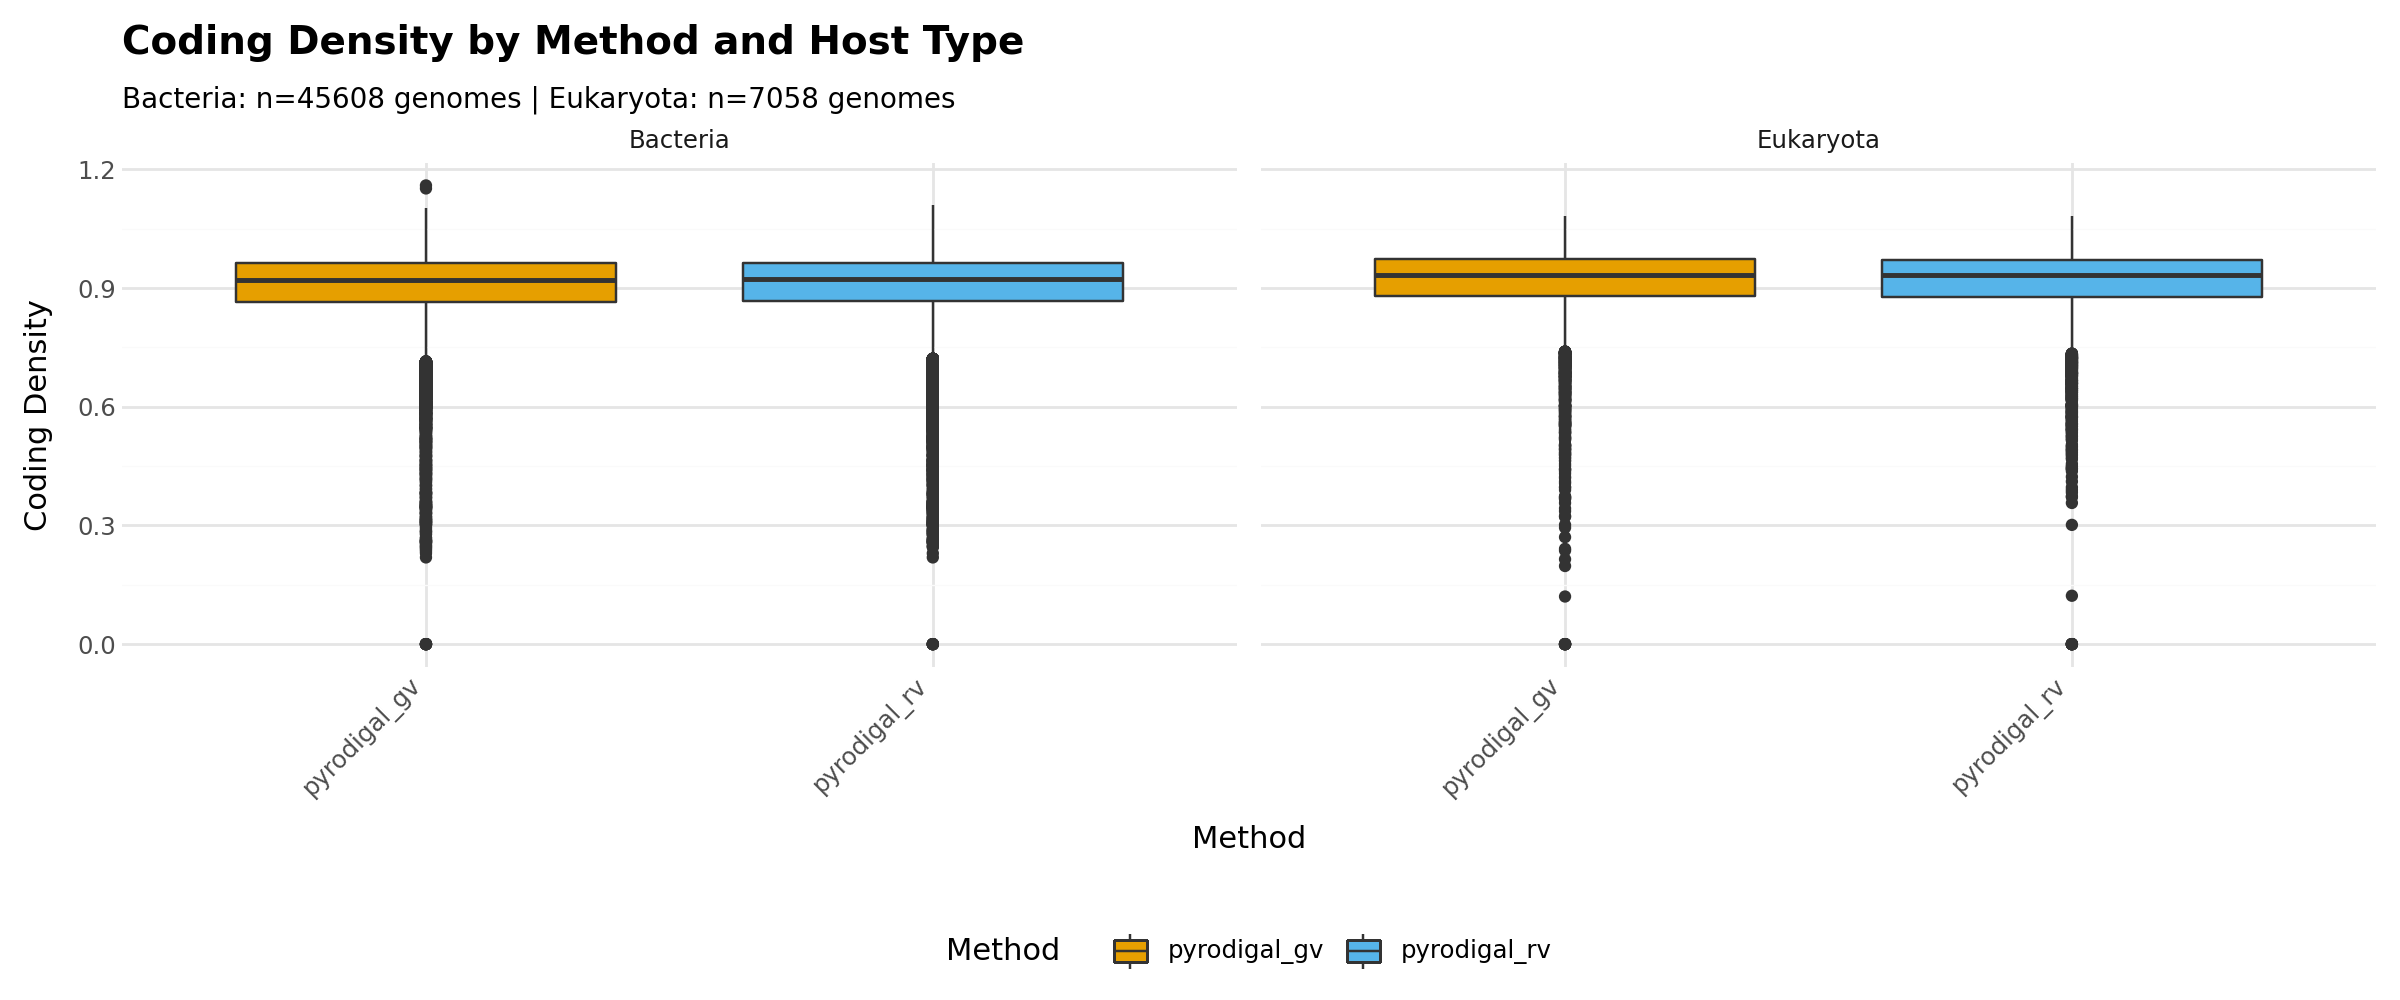

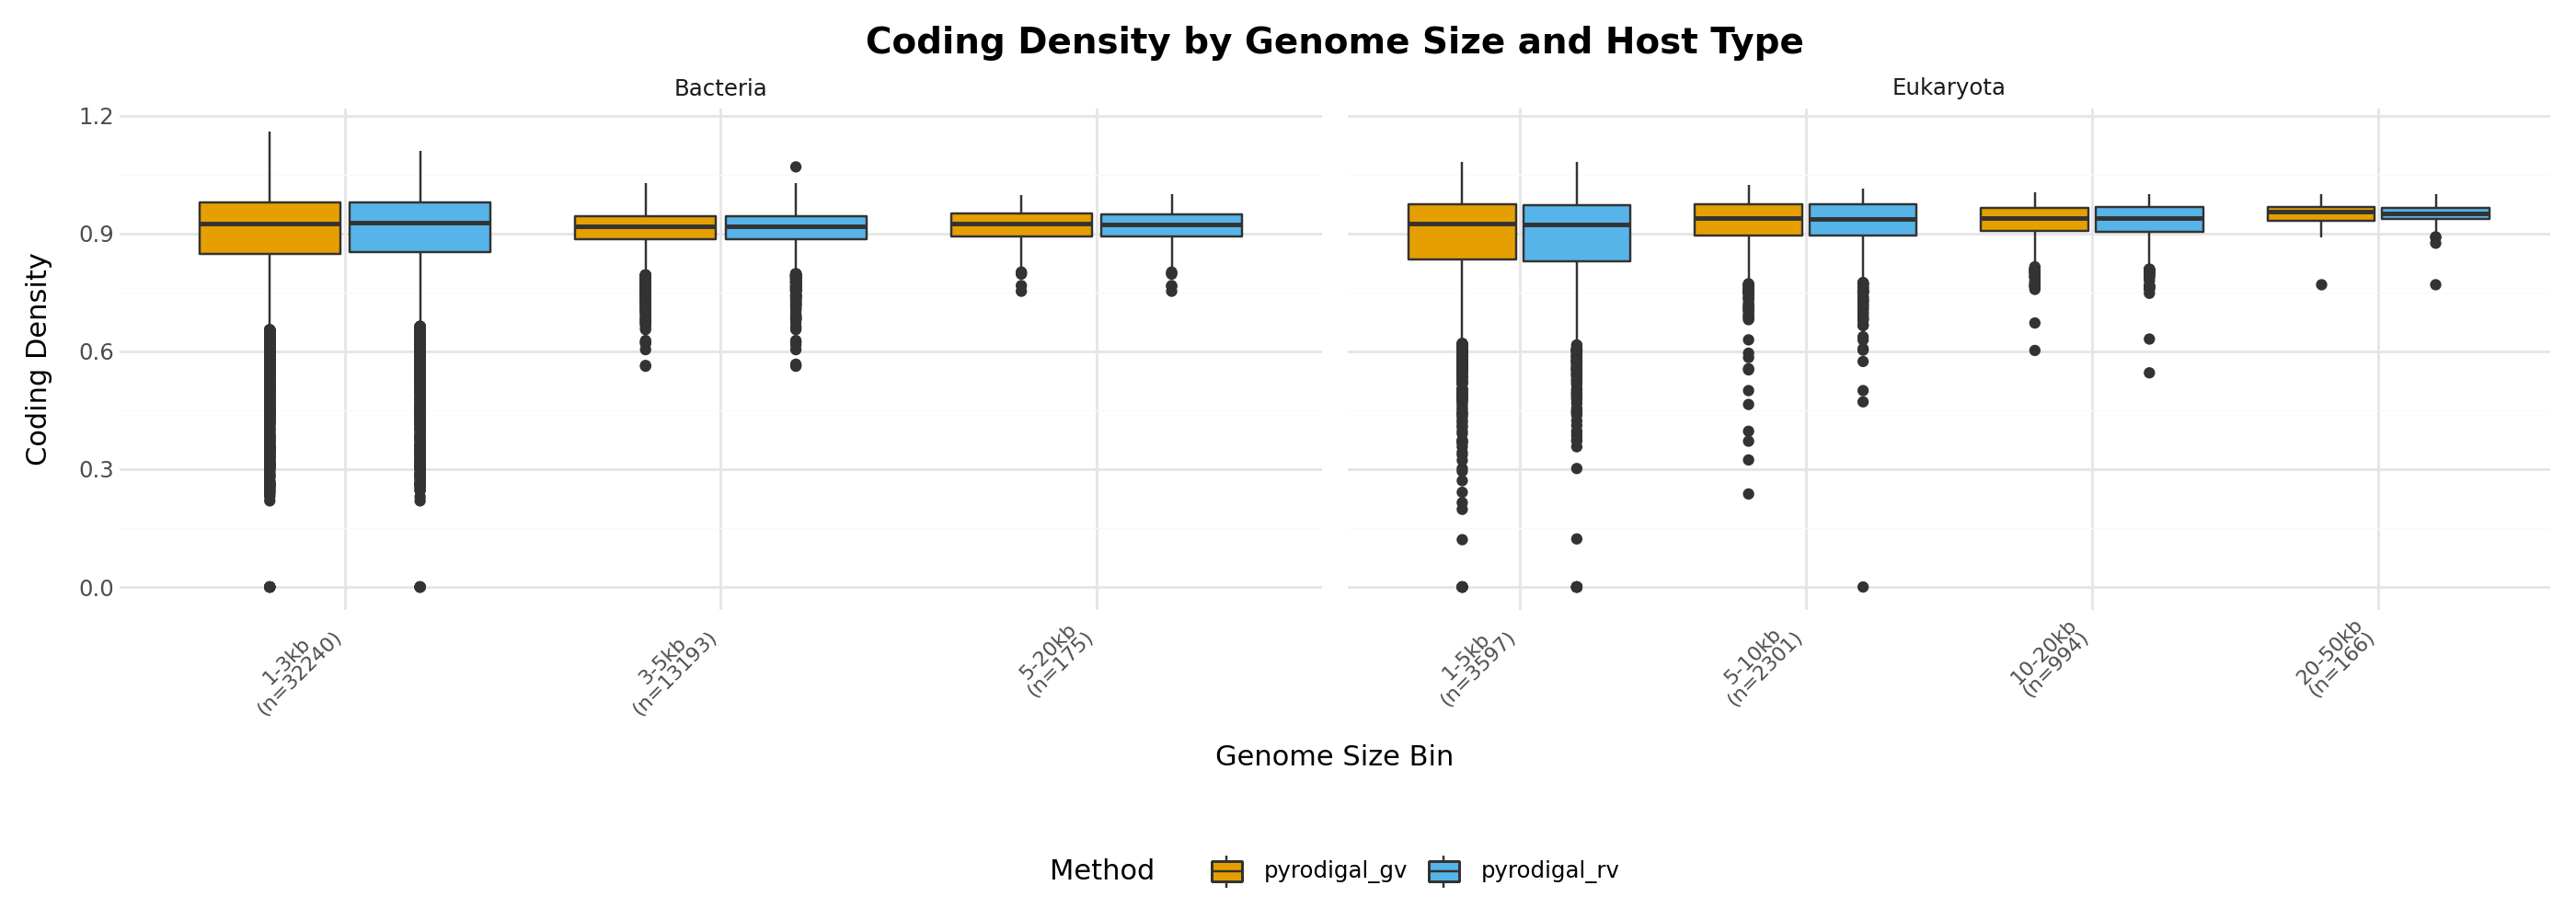


Coding Density - Summary Statistics by Host and Method:


Bacteria:
  pyrodigal_gv: mean=0.902, median=0.921
  pyrodigal_rv: mean=0.904, median=0.923
  Difference (GV - RV): -0.002

Eukaryota:
  pyrodigal_gv: mean=0.907, median=0.934
  pyrodigal_rv: mean=0.906, median=0.933
  Difference (GV - RV): 0.001

Comparing: No RBS Frequency


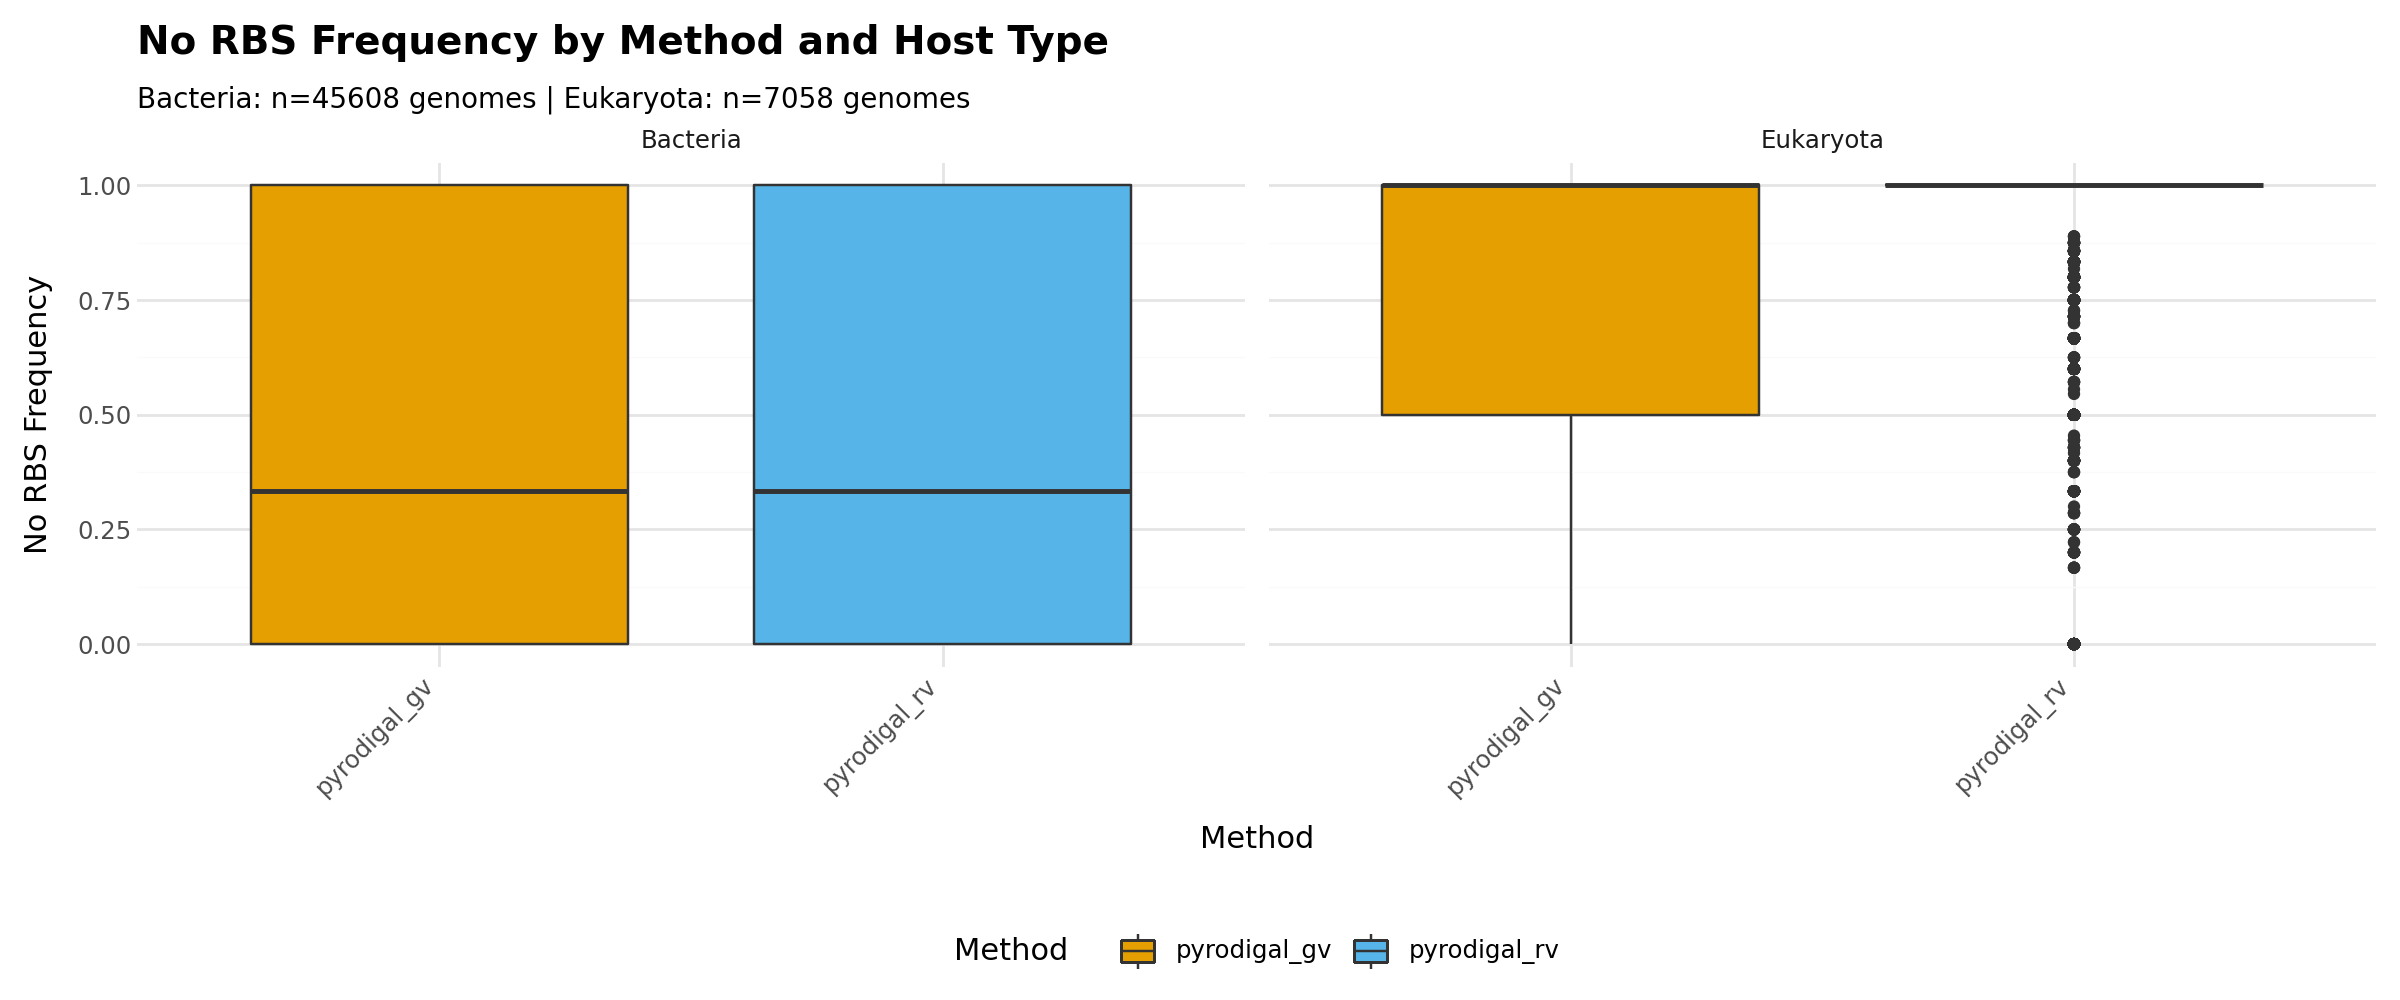

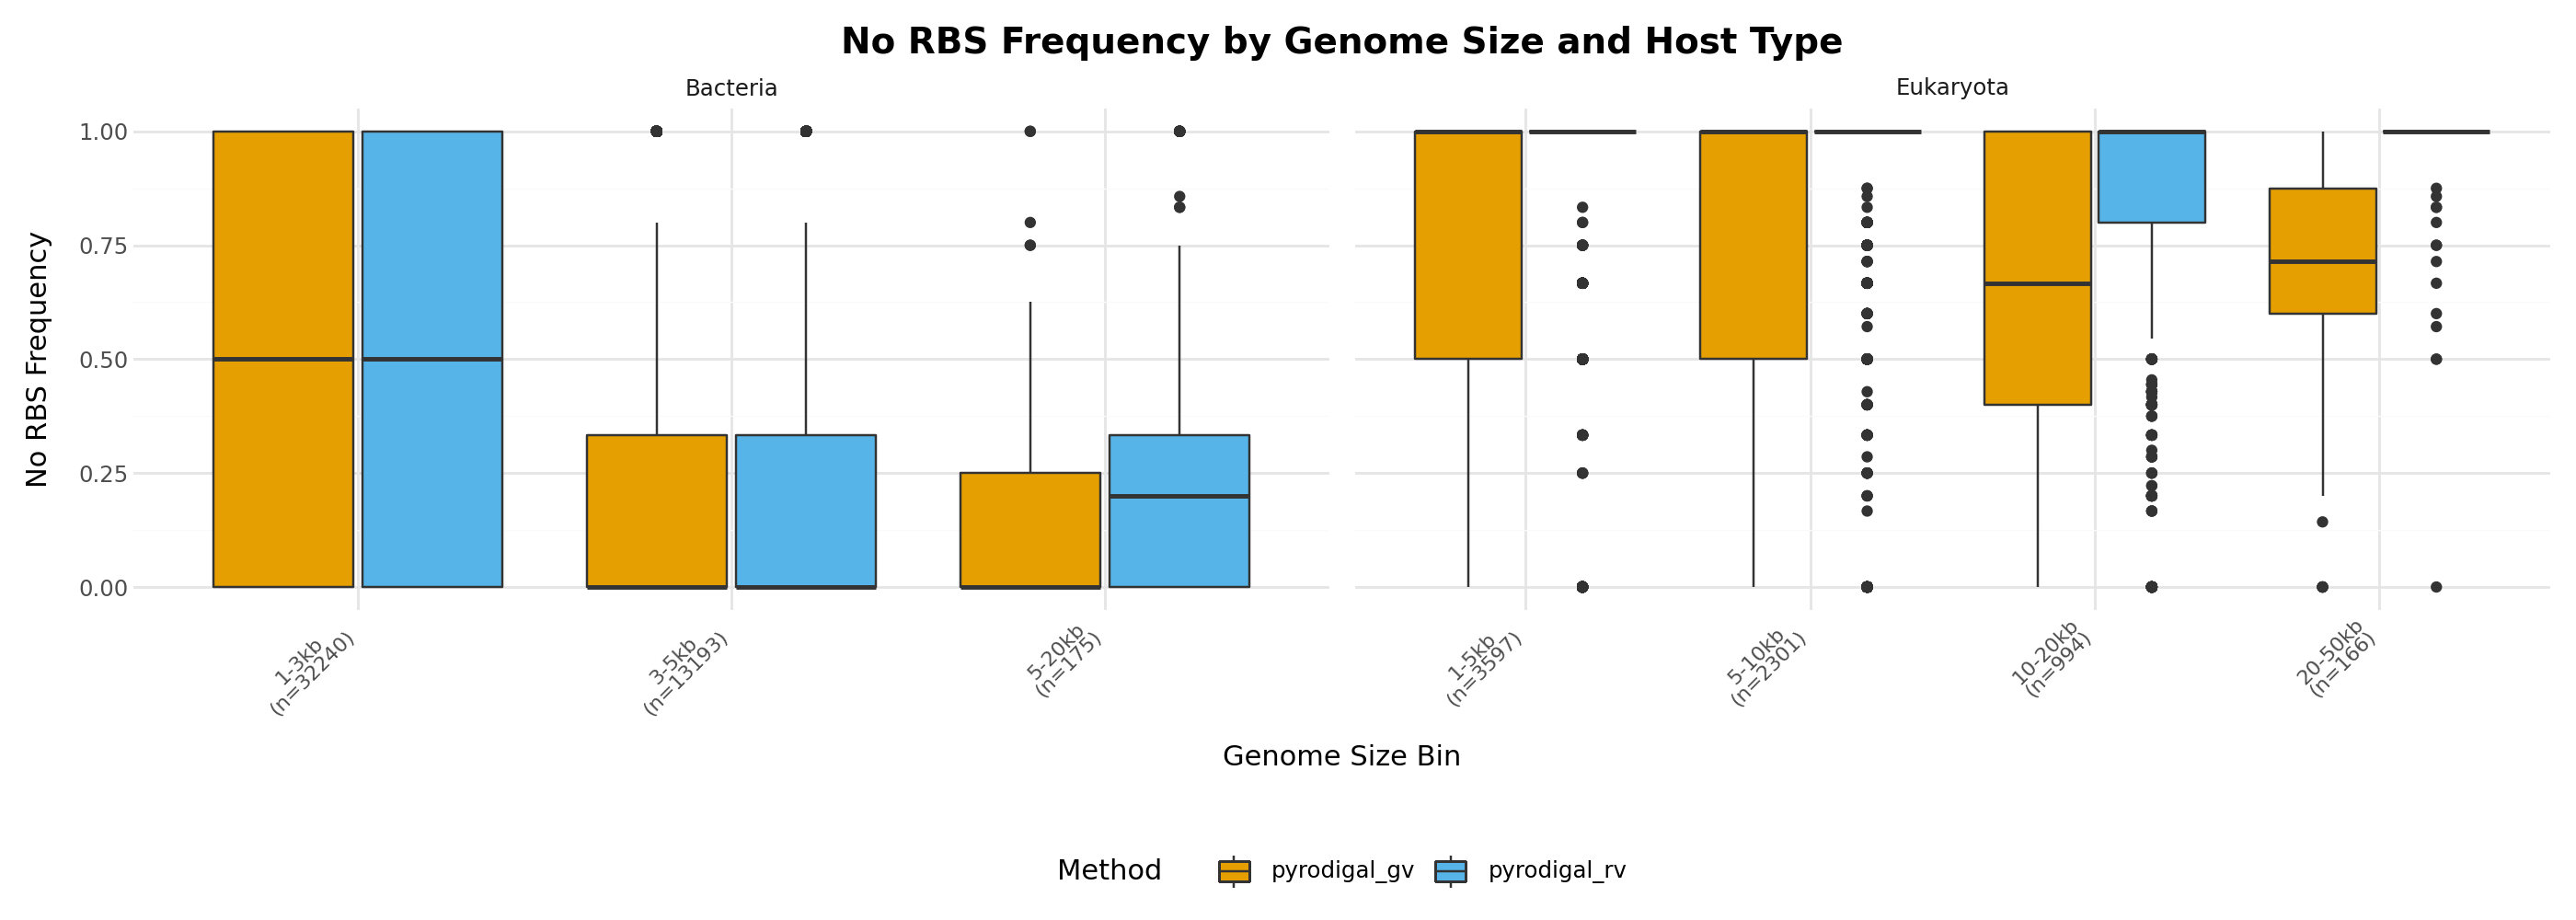


No RBS Frequency - Summary Statistics by Host and Method:


Bacteria:
  pyrodigal_gv: mean=0.424, median=0.333
  pyrodigal_rv: mean=0.426, median=0.333
  Difference (GV - RV): -0.002

Eukaryota:
  pyrodigal_gv: mean=0.729, median=1.000
  pyrodigal_rv: mean=0.891, median=1.000
  Difference (GV - RV): -0.162

Comparing: Bacteroidetes RBS Frequency


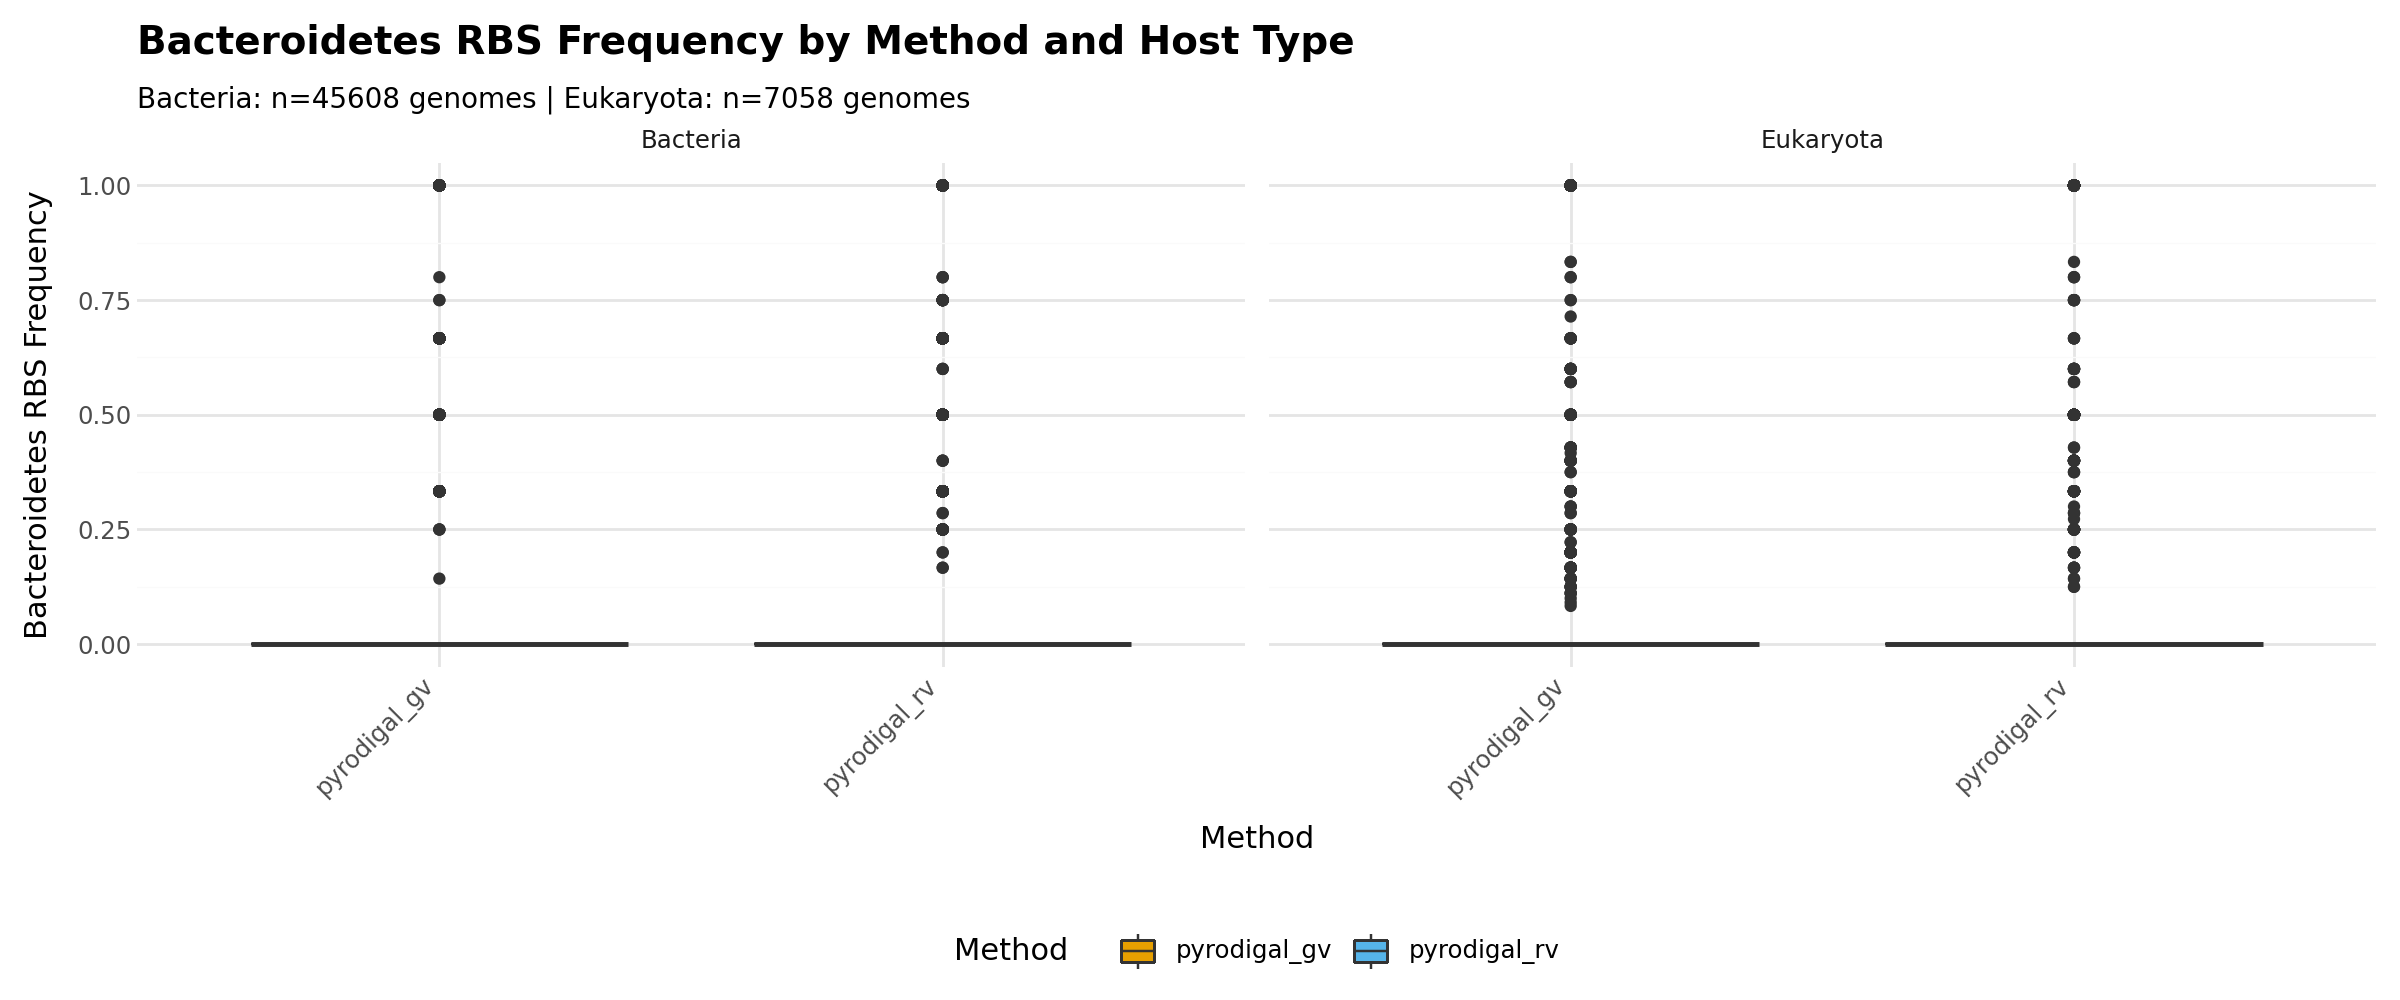

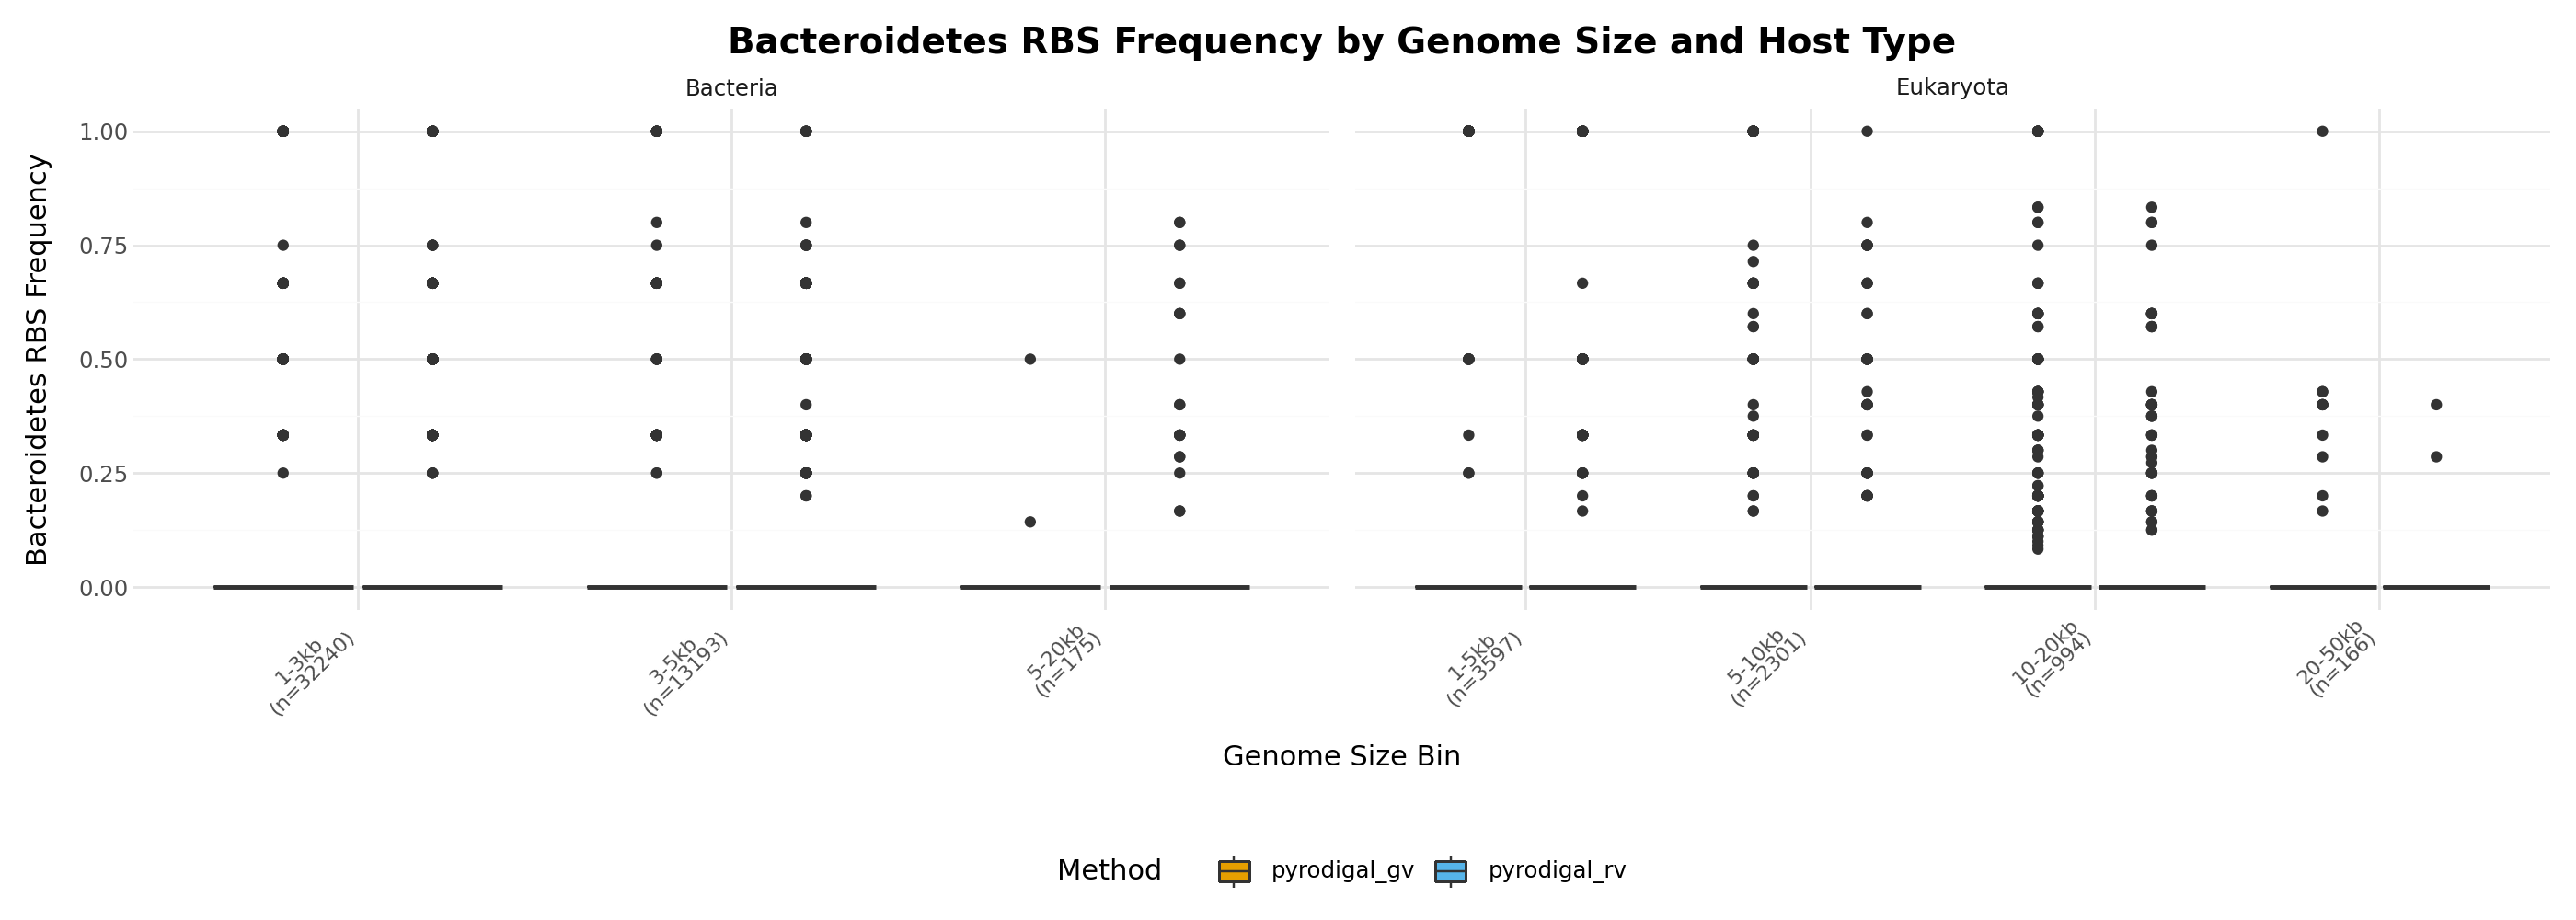


Bacteroidetes RBS Frequency - Summary Statistics by Host and Method:


Bacteria:
  pyrodigal_gv: mean=0.003, median=0.000
  pyrodigal_rv: mean=0.007, median=0.000
  Difference (GV - RV): -0.003

Eukaryota:
  pyrodigal_gv: mean=0.029, median=0.000
  pyrodigal_rv: mean=0.022, median=0.000
  Difference (GV - RV): 0.006

Comparing: Canonical SD RBS Frequency


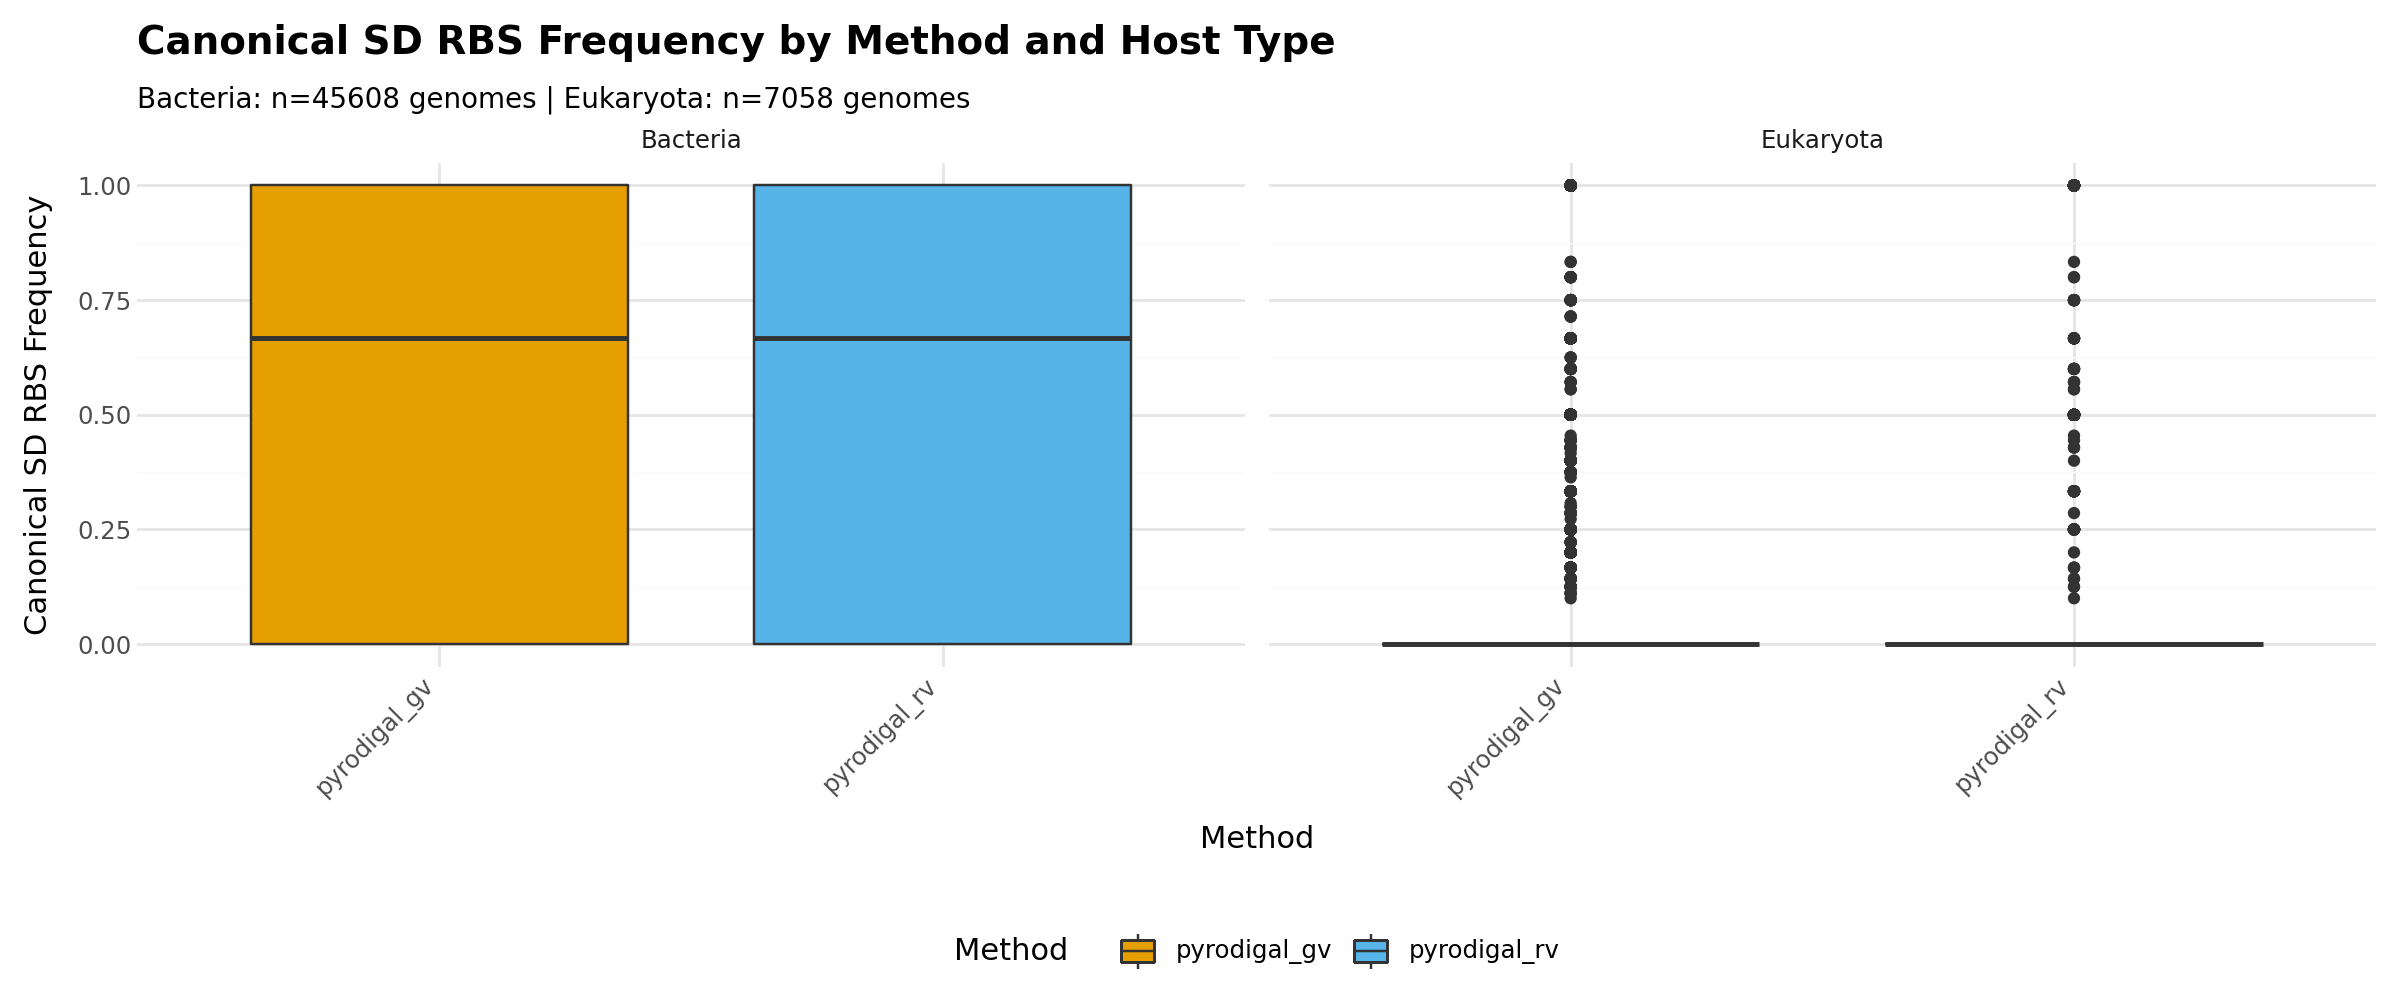

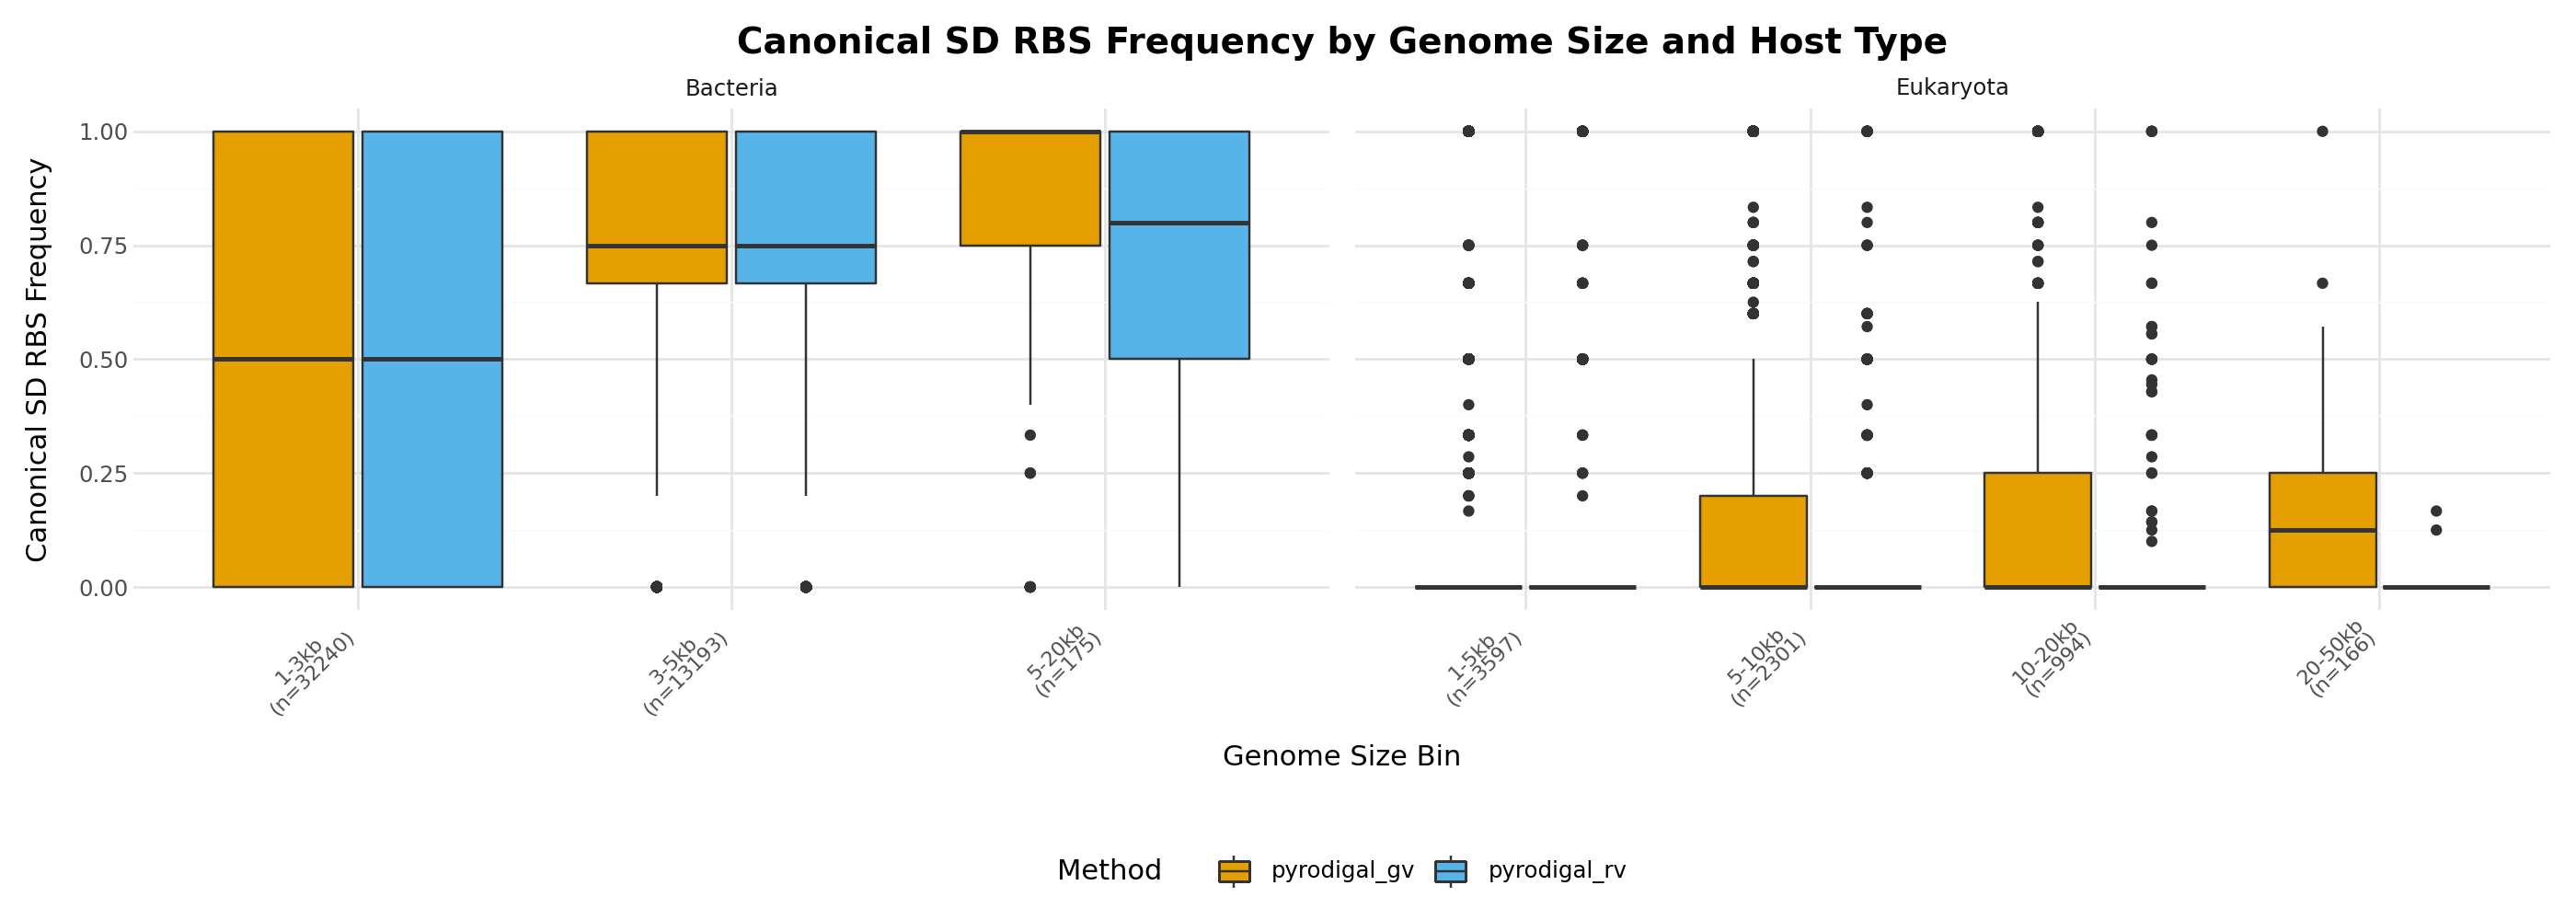


Canonical SD RBS Frequency - Summary Statistics by Host and Method:


Bacteria:
  pyrodigal_gv: mean=0.544, median=0.667
  pyrodigal_rv: mean=0.551, median=0.667
  Difference (GV - RV): -0.007

Eukaryota:
  pyrodigal_gv: mean=0.134, median=0.000
  pyrodigal_rv: mean=0.018, median=0.000
  Difference (GV - RV): 0.116

Comparing: TATATA RBS Frequency


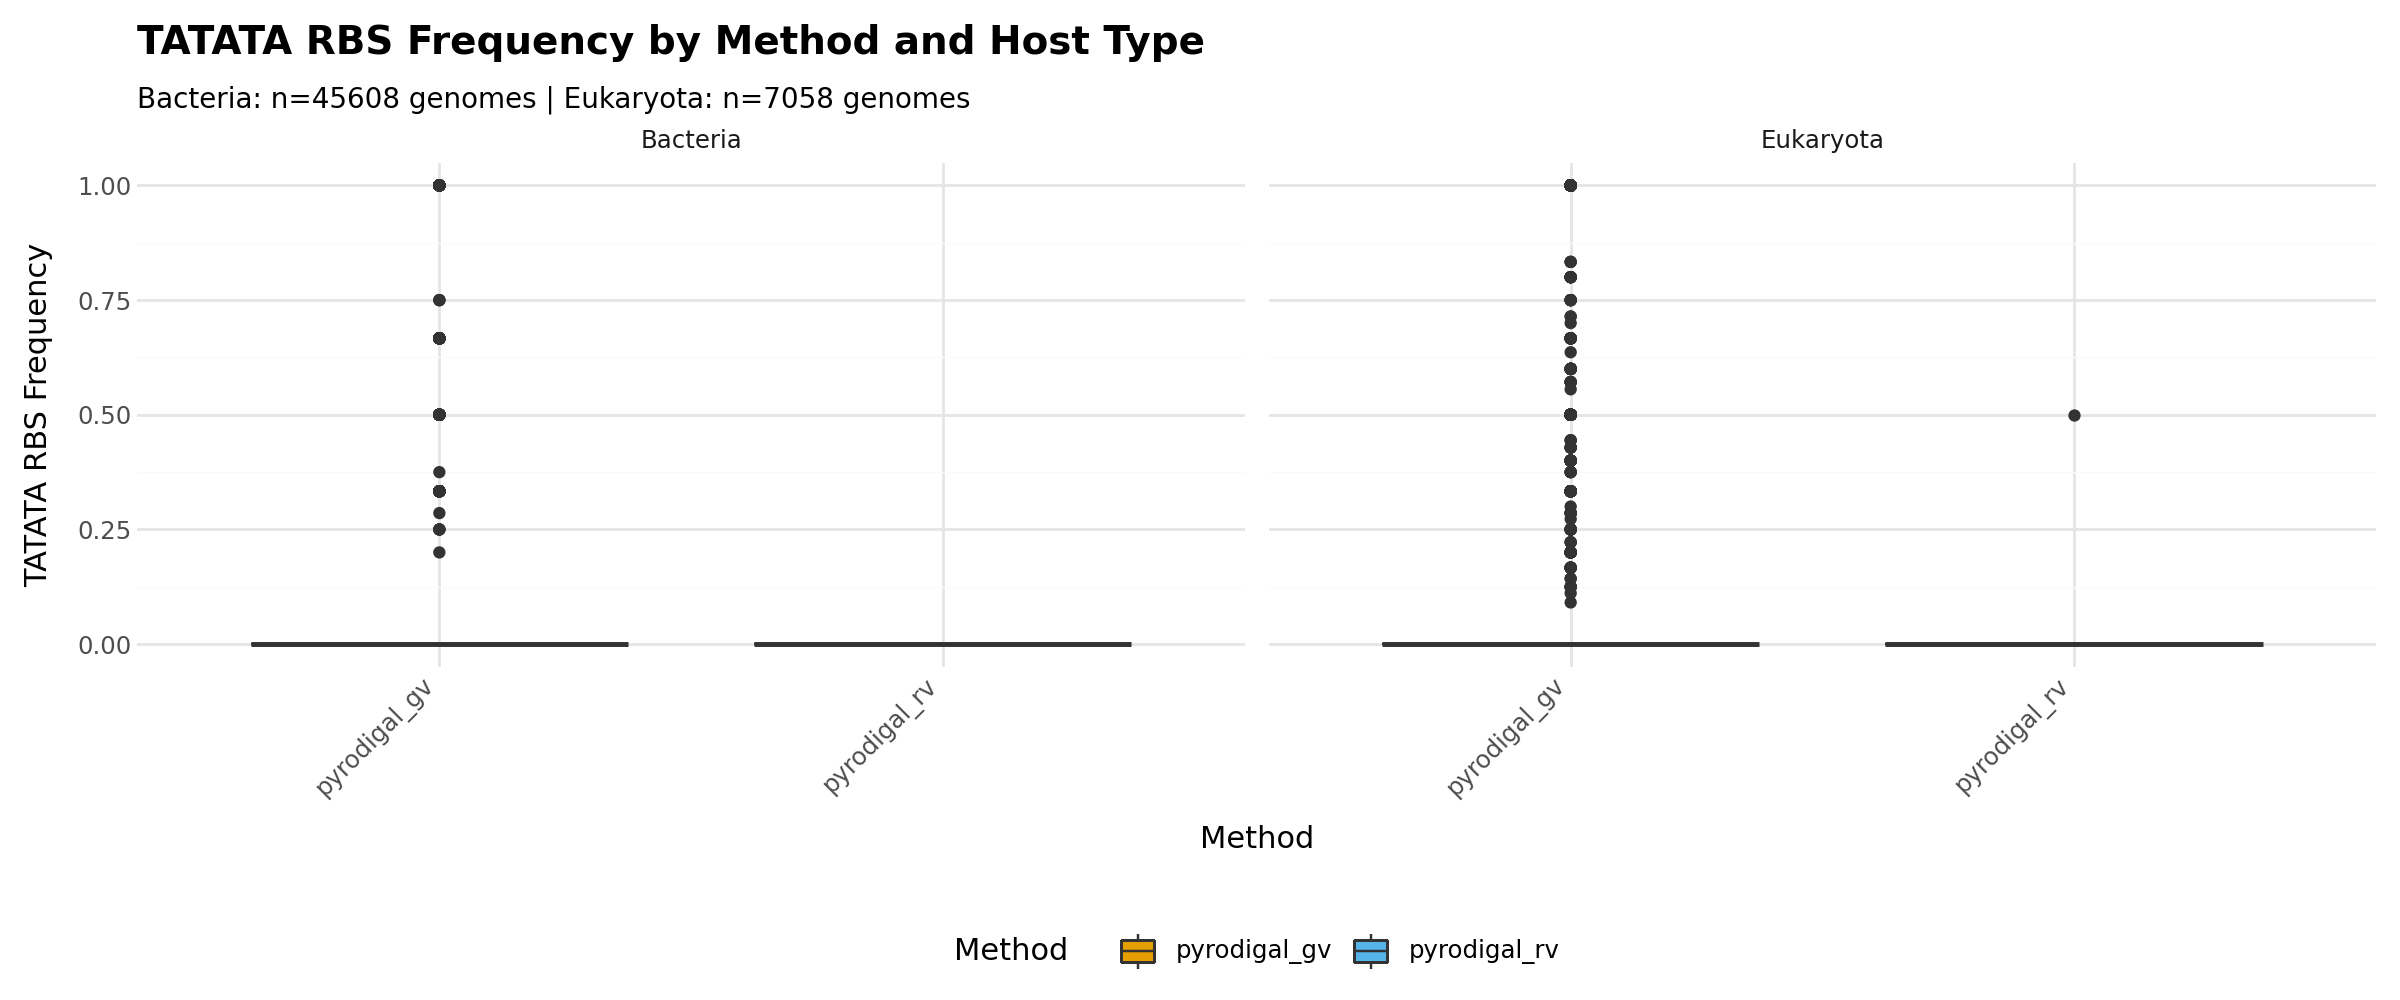

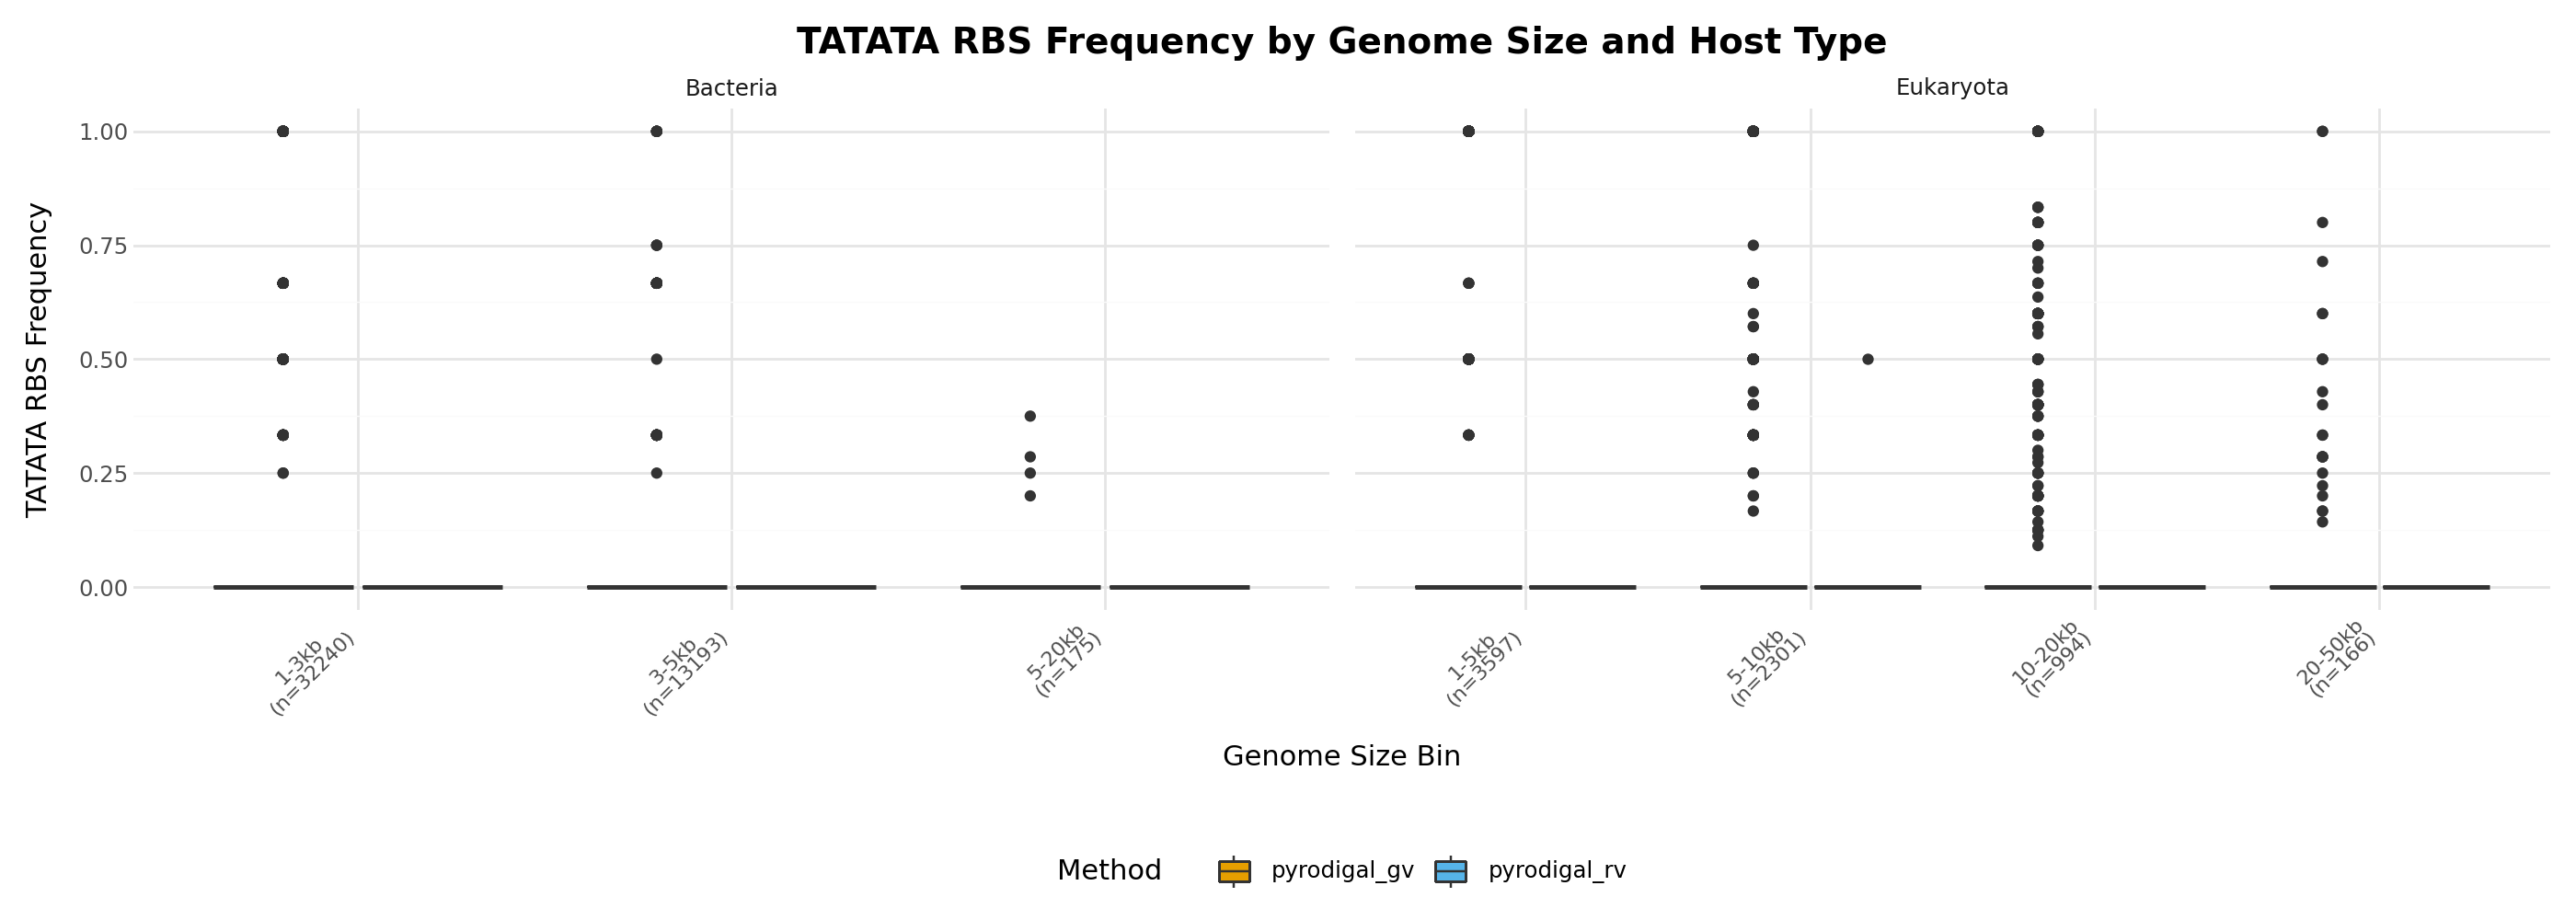


TATATA RBS Frequency - Summary Statistics by Host and Method:


Bacteria:
  pyrodigal_gv: mean=0.003, median=0.000
  pyrodigal_rv: mean=0.000, median=0.000
  Difference (GV - RV): 0.003

Eukaryota:
  pyrodigal_gv: mean=0.052, median=0.000
  pyrodigal_rv: mean=0.000, median=0.000
  Difference (GV - RV): 0.052

Comparing: Mean RBS Score


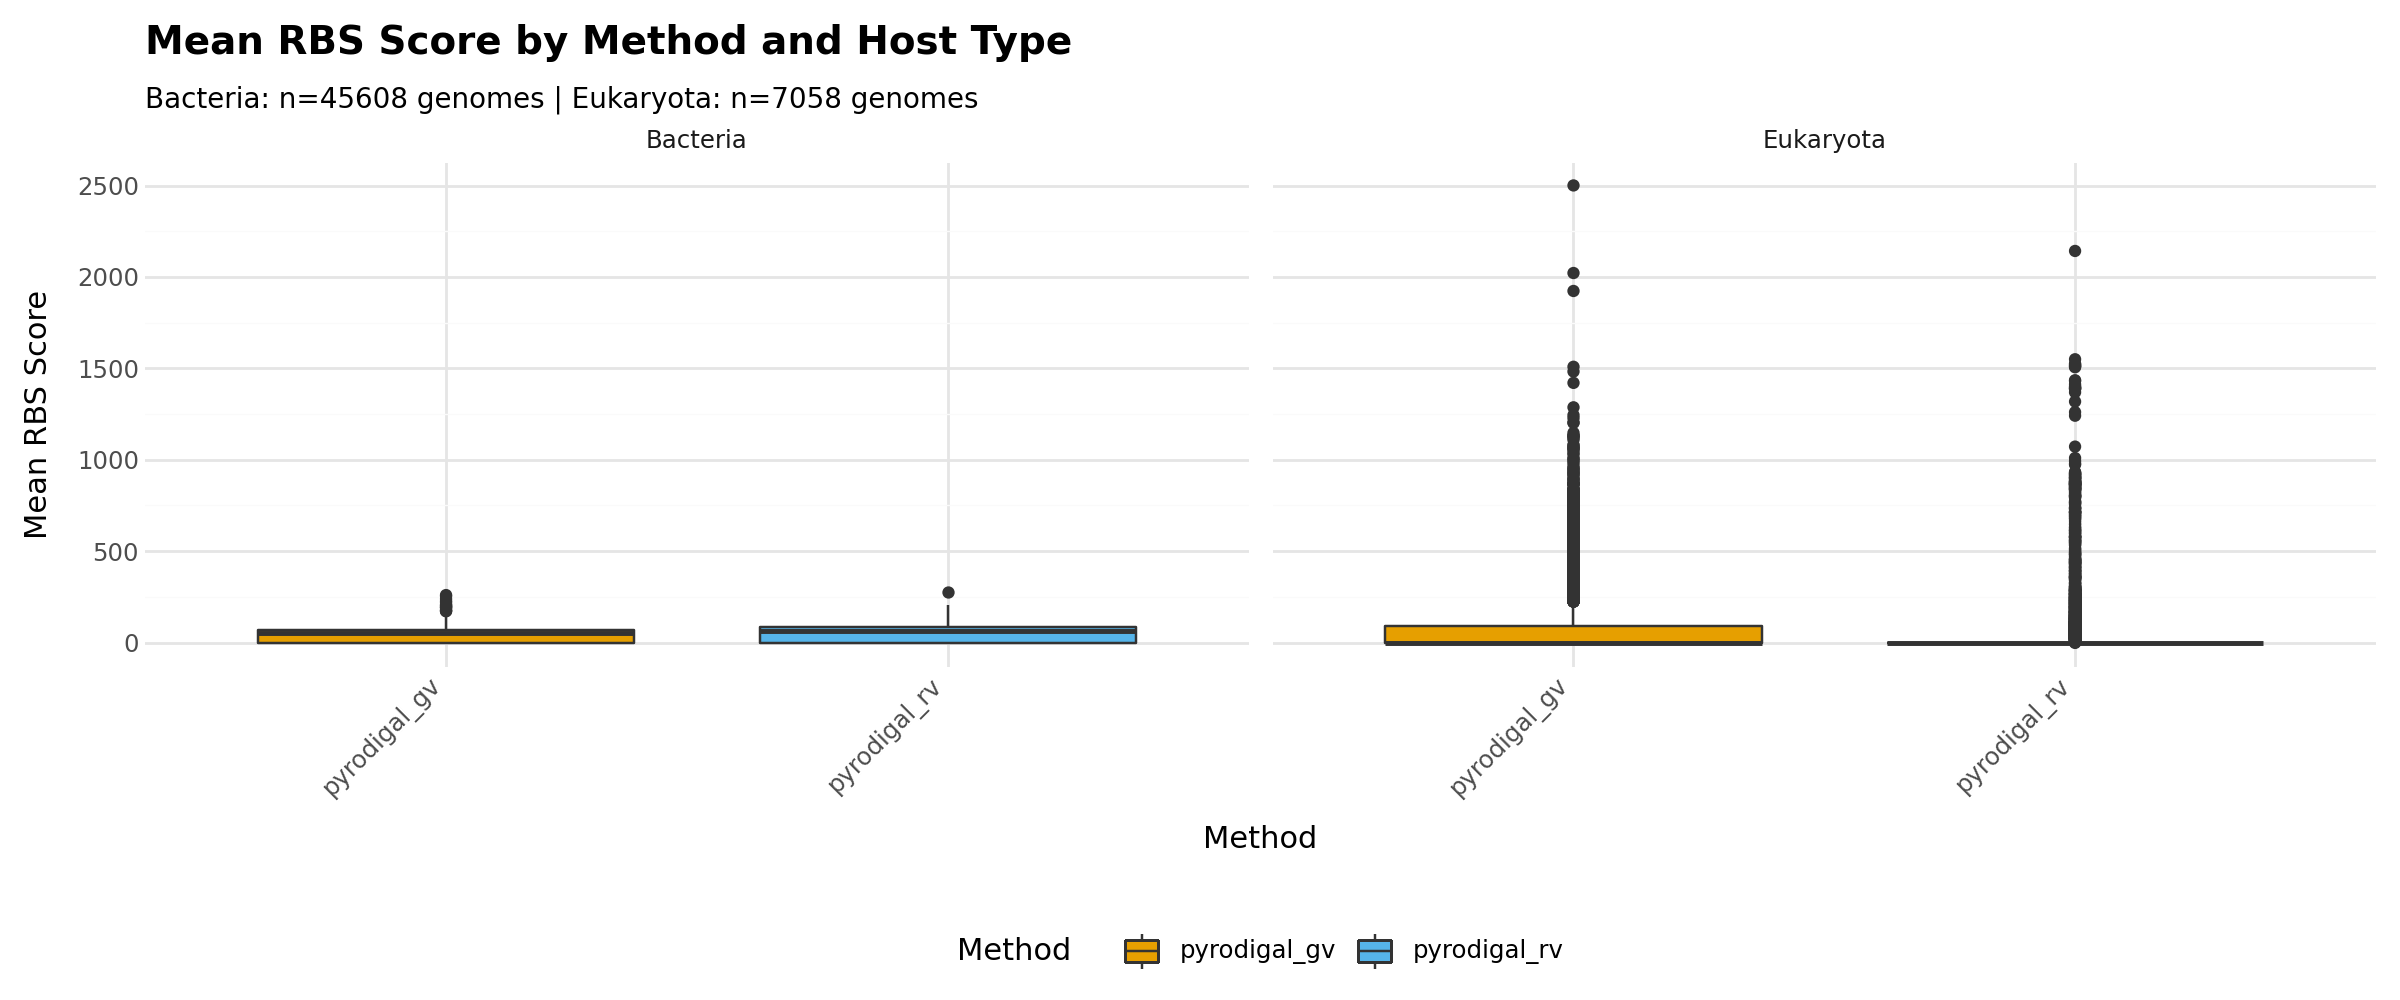

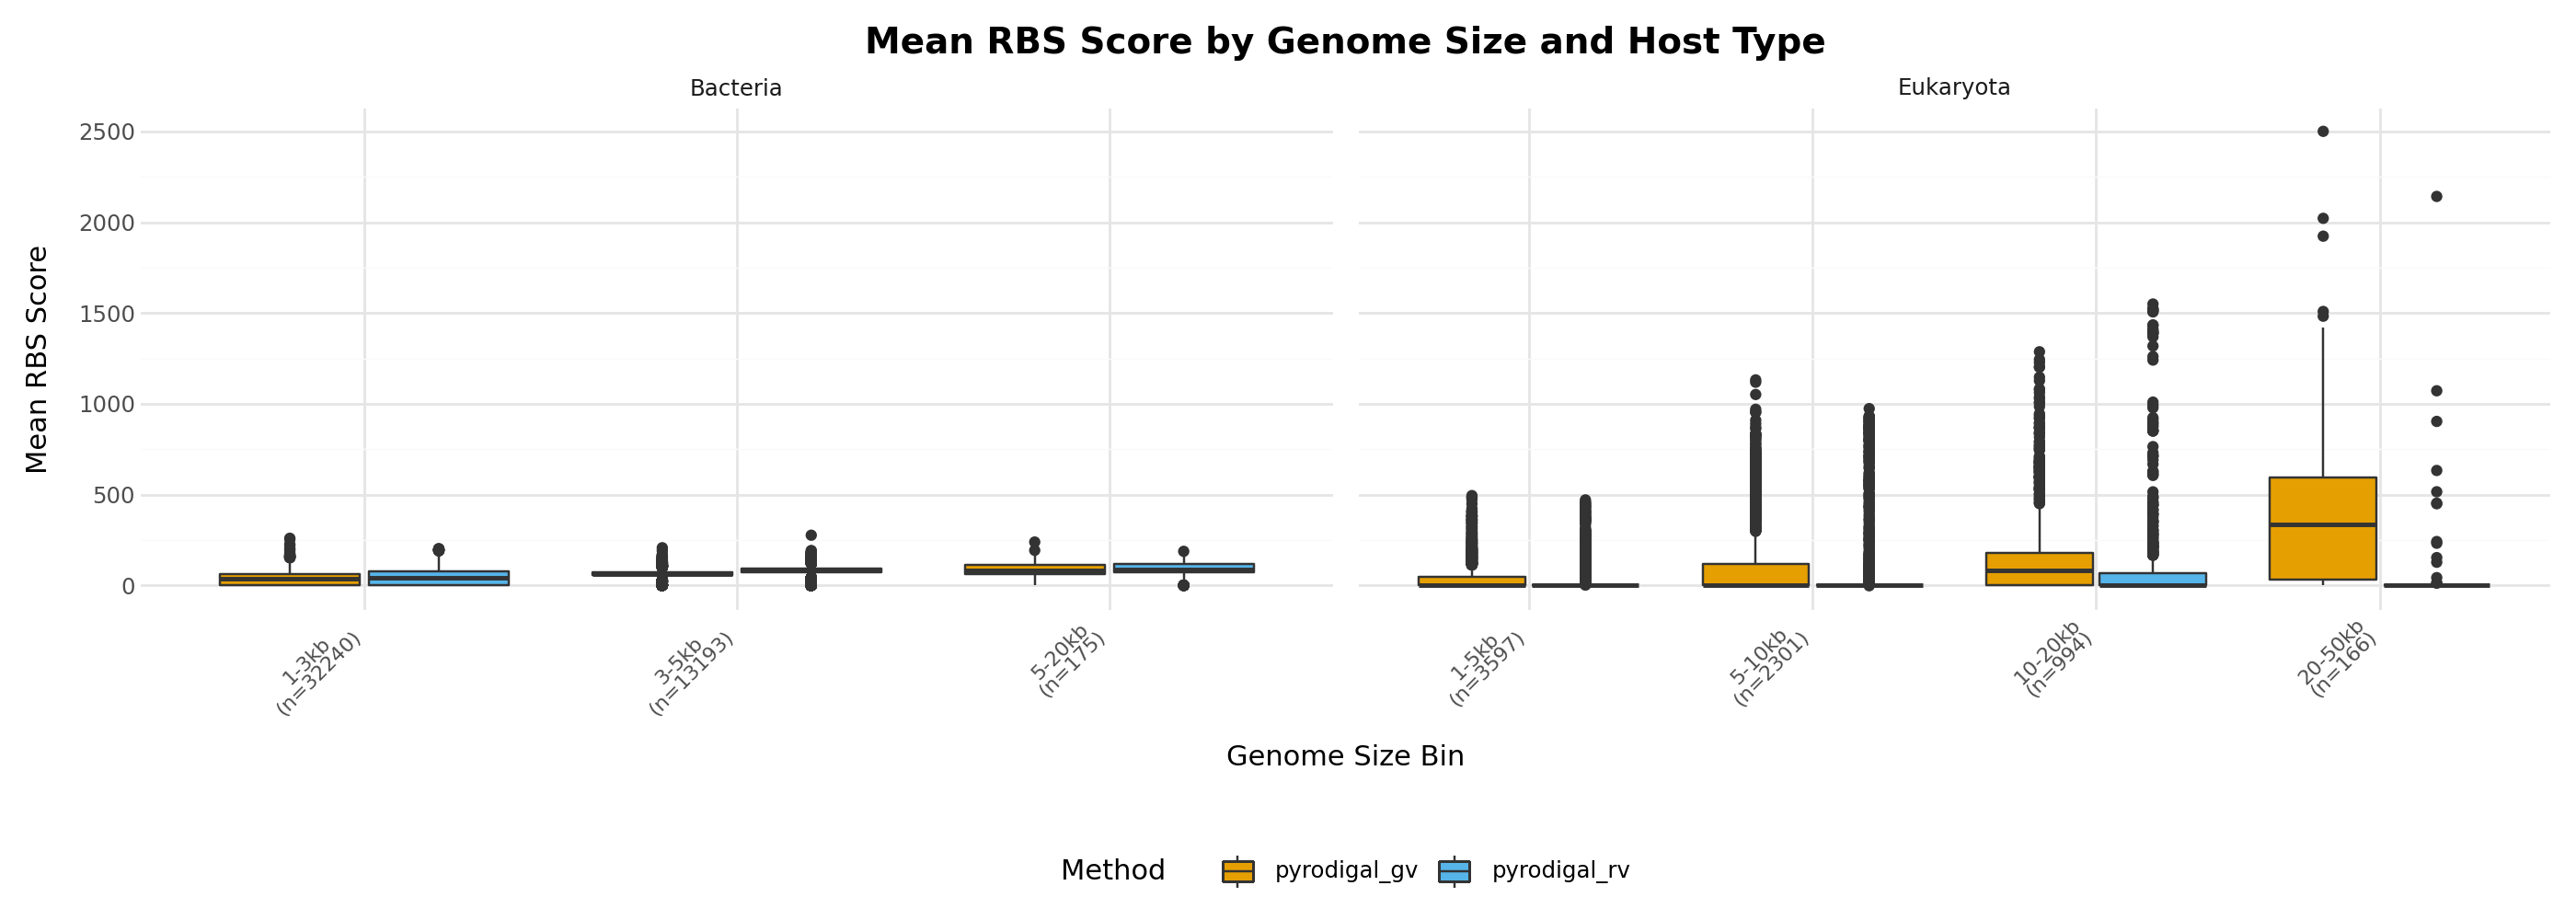


Mean RBS Score - Summary Statistics by Host and Method:


Bacteria:
  pyrodigal_gv: mean=44.033, median=49.342
  pyrodigal_rv: mean=55.101, median=61.902
  Difference (GV - RV): -11.068

Eukaryota:
  pyrodigal_gv: mean=84.476, median=0.000
  pyrodigal_rv: mean=40.096, median=0.000
  Difference (GV - RV): 44.380

Comparing: Gene Density (genes/kb)


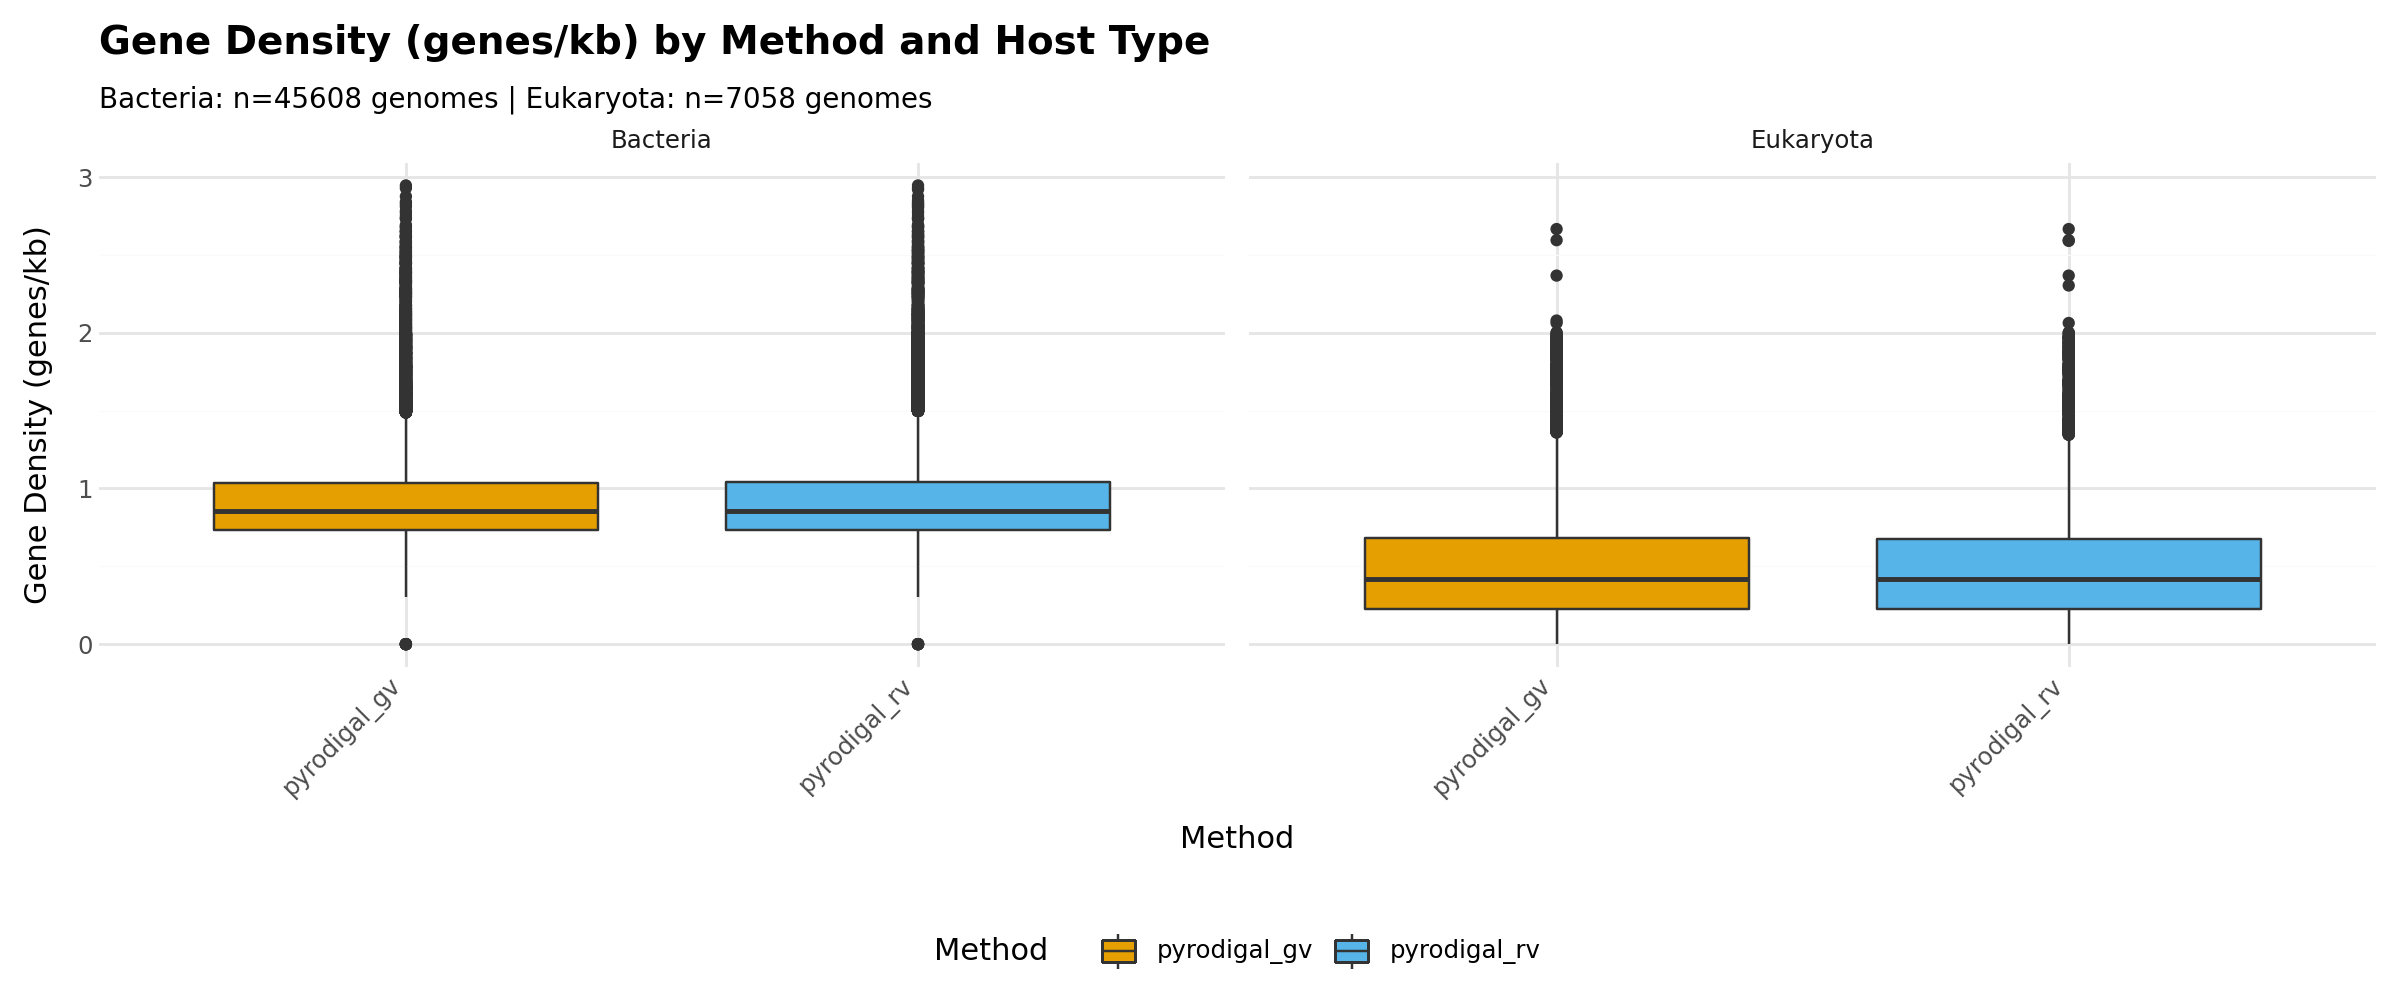

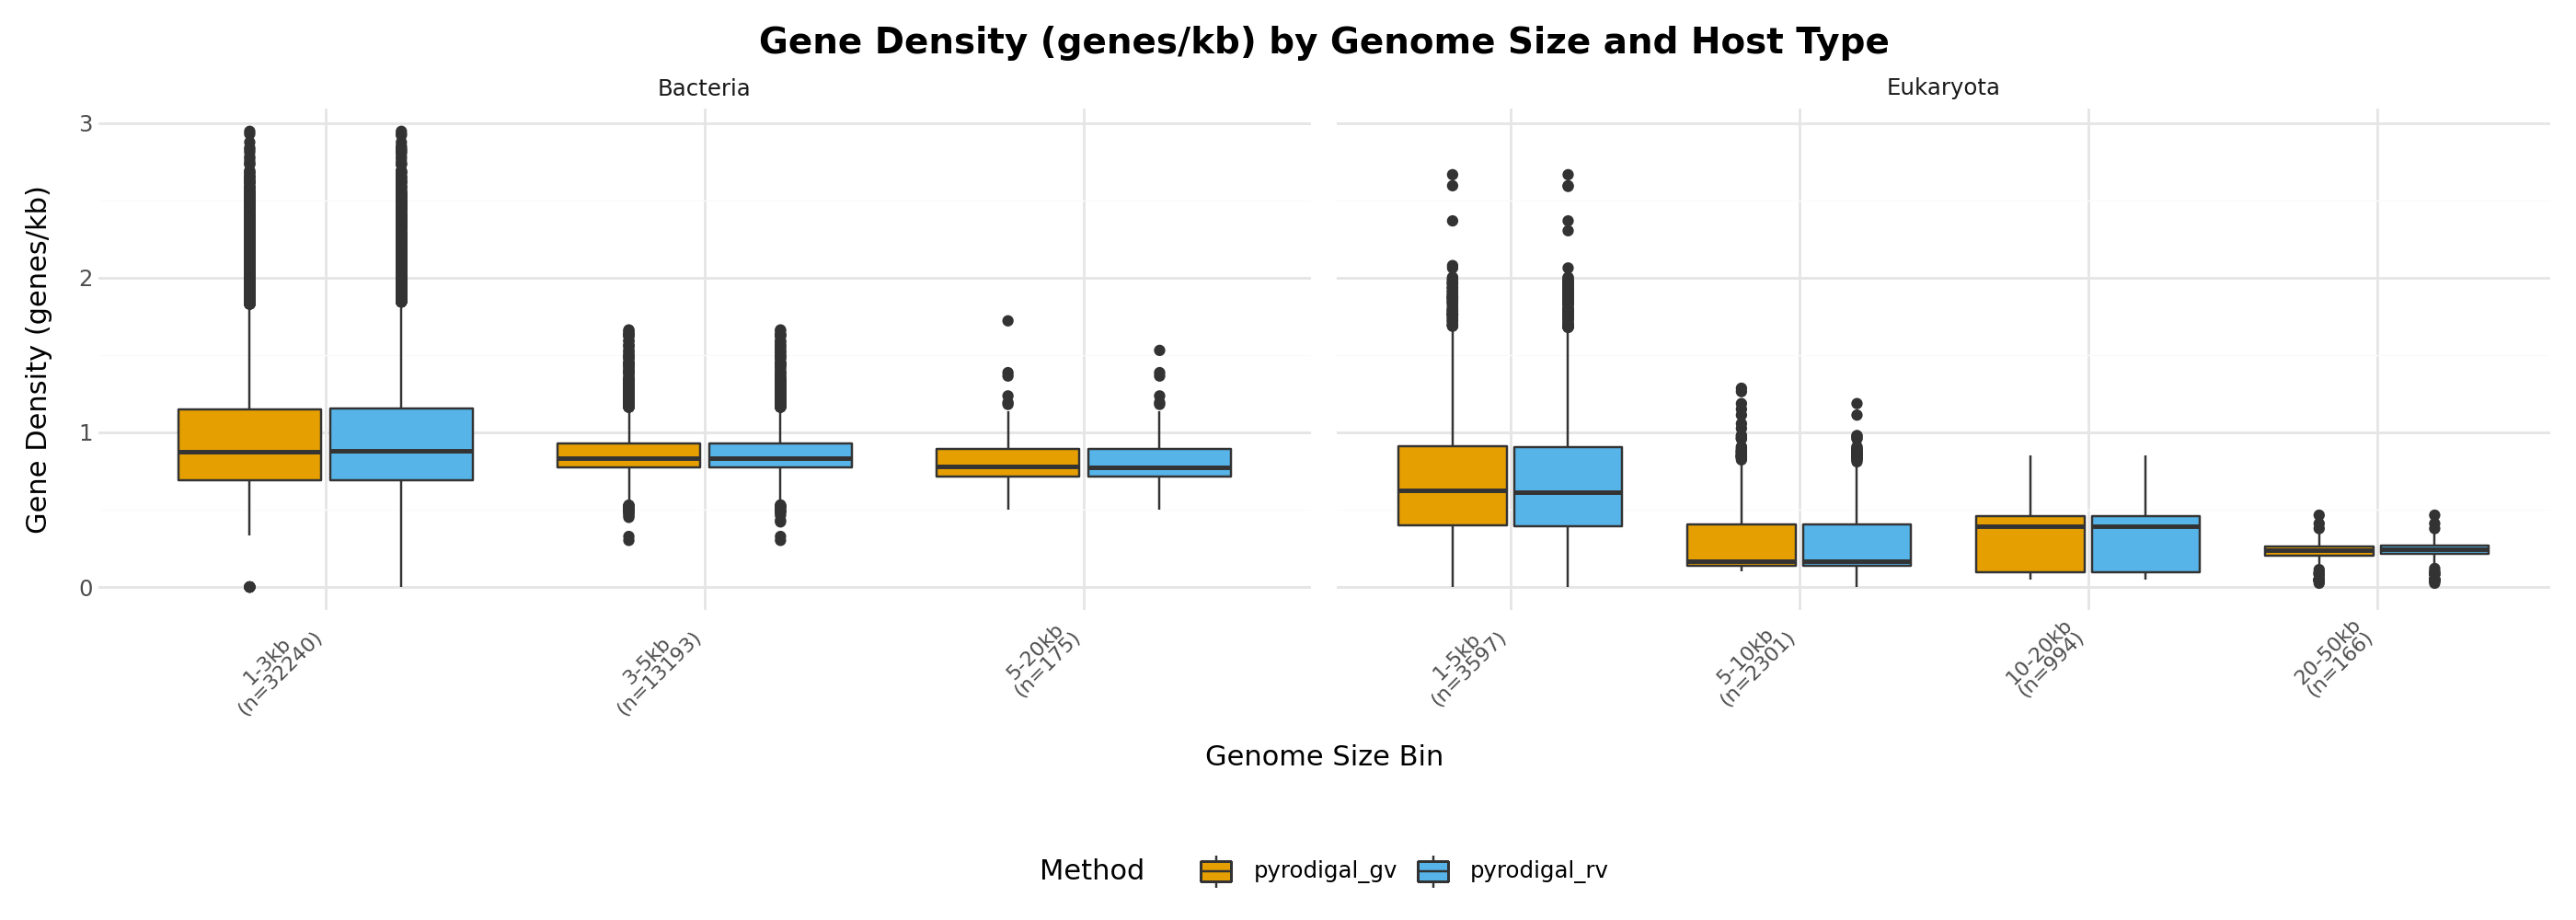


Gene Density (genes/kb) - Summary Statistics by Host and Method:


Bacteria:
  pyrodigal_gv: mean=0.933, median=0.853
  pyrodigal_rv: mean=0.937, median=0.855
  Difference (GV - RV): -0.003

Eukaryota:
  pyrodigal_gv: mean=0.503, median=0.420
  pyrodigal_rv: mean=0.499, median=0.417
  Difference (GV - RV): 0.004

Comparing: Leaderless Frequency


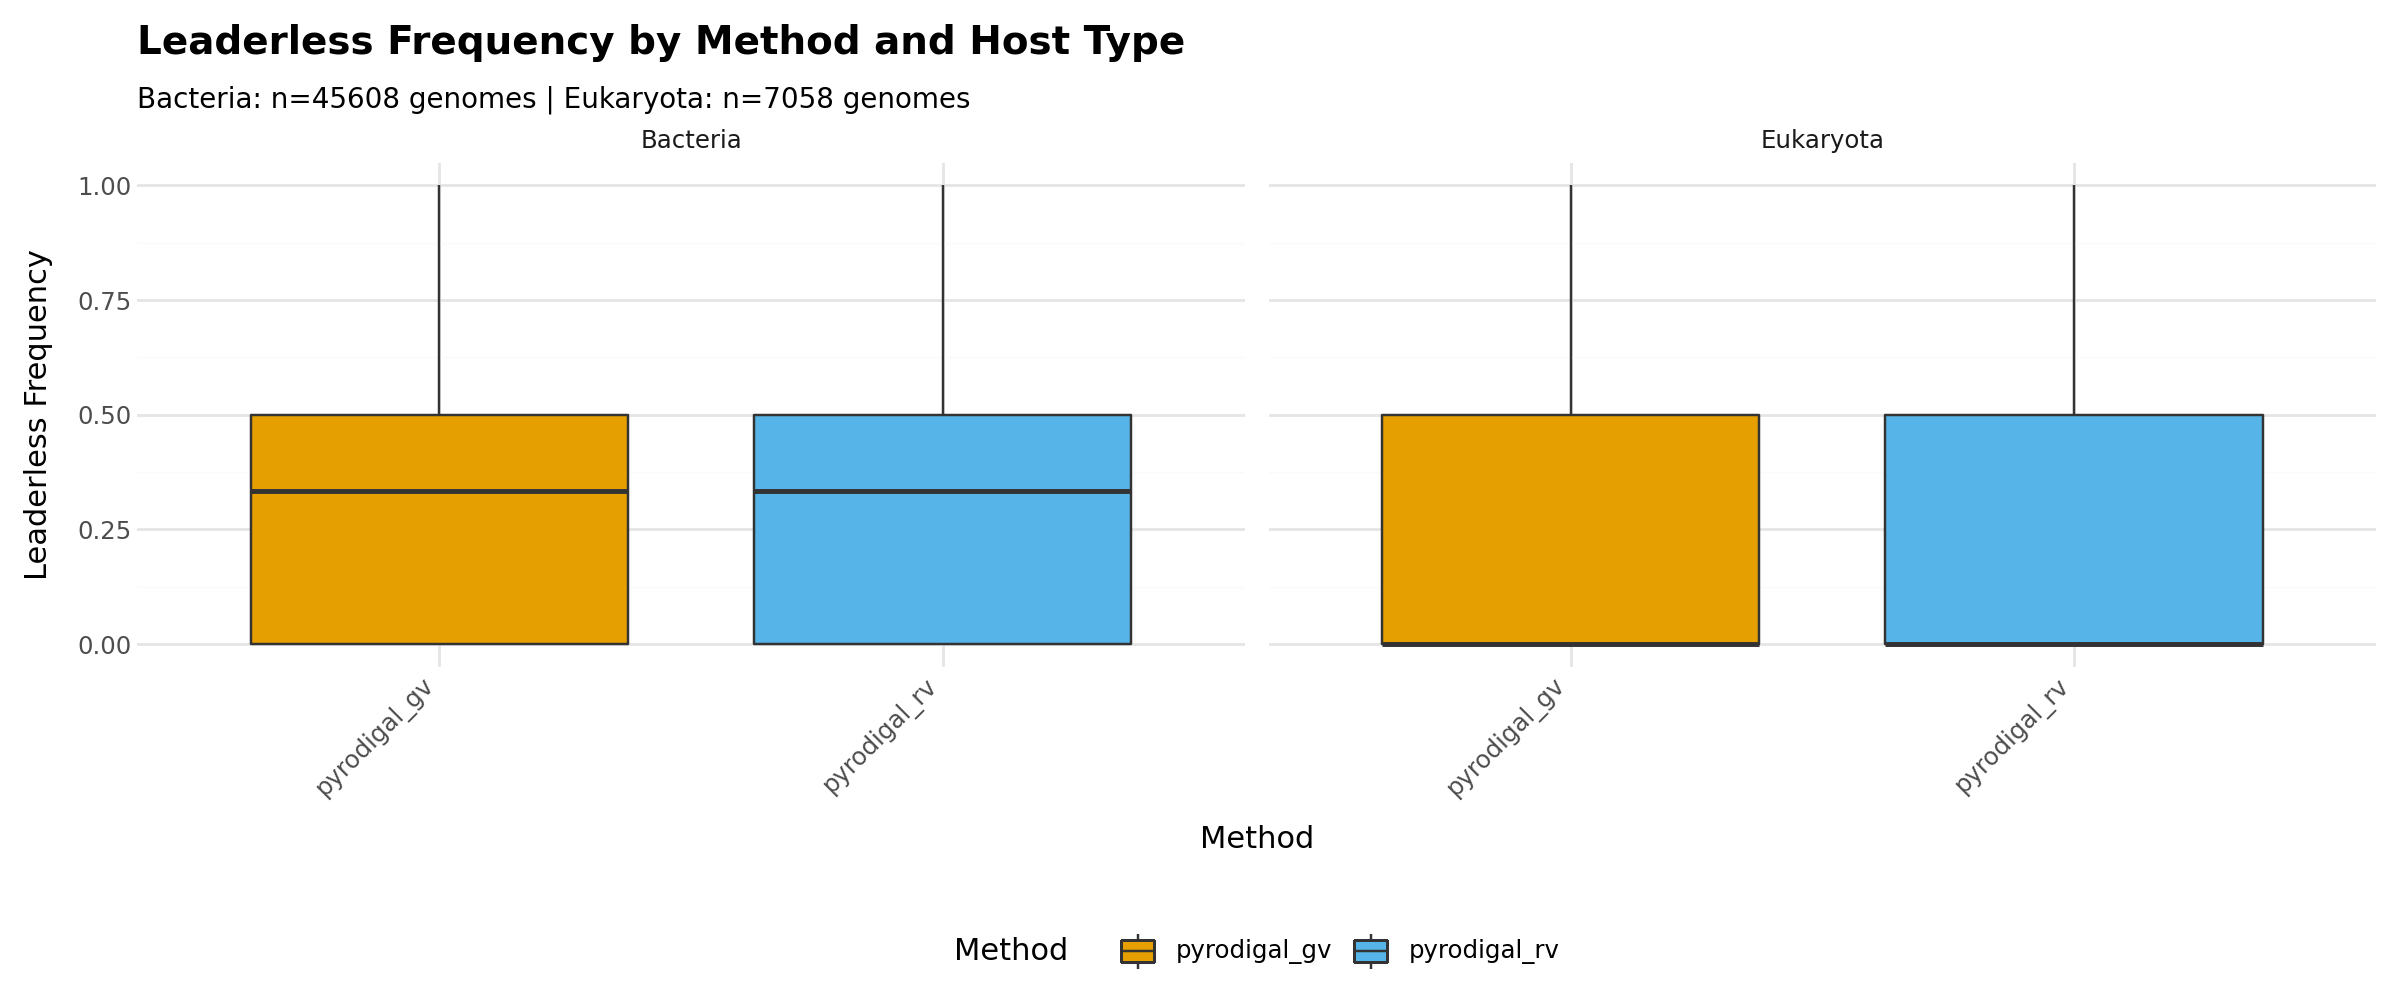

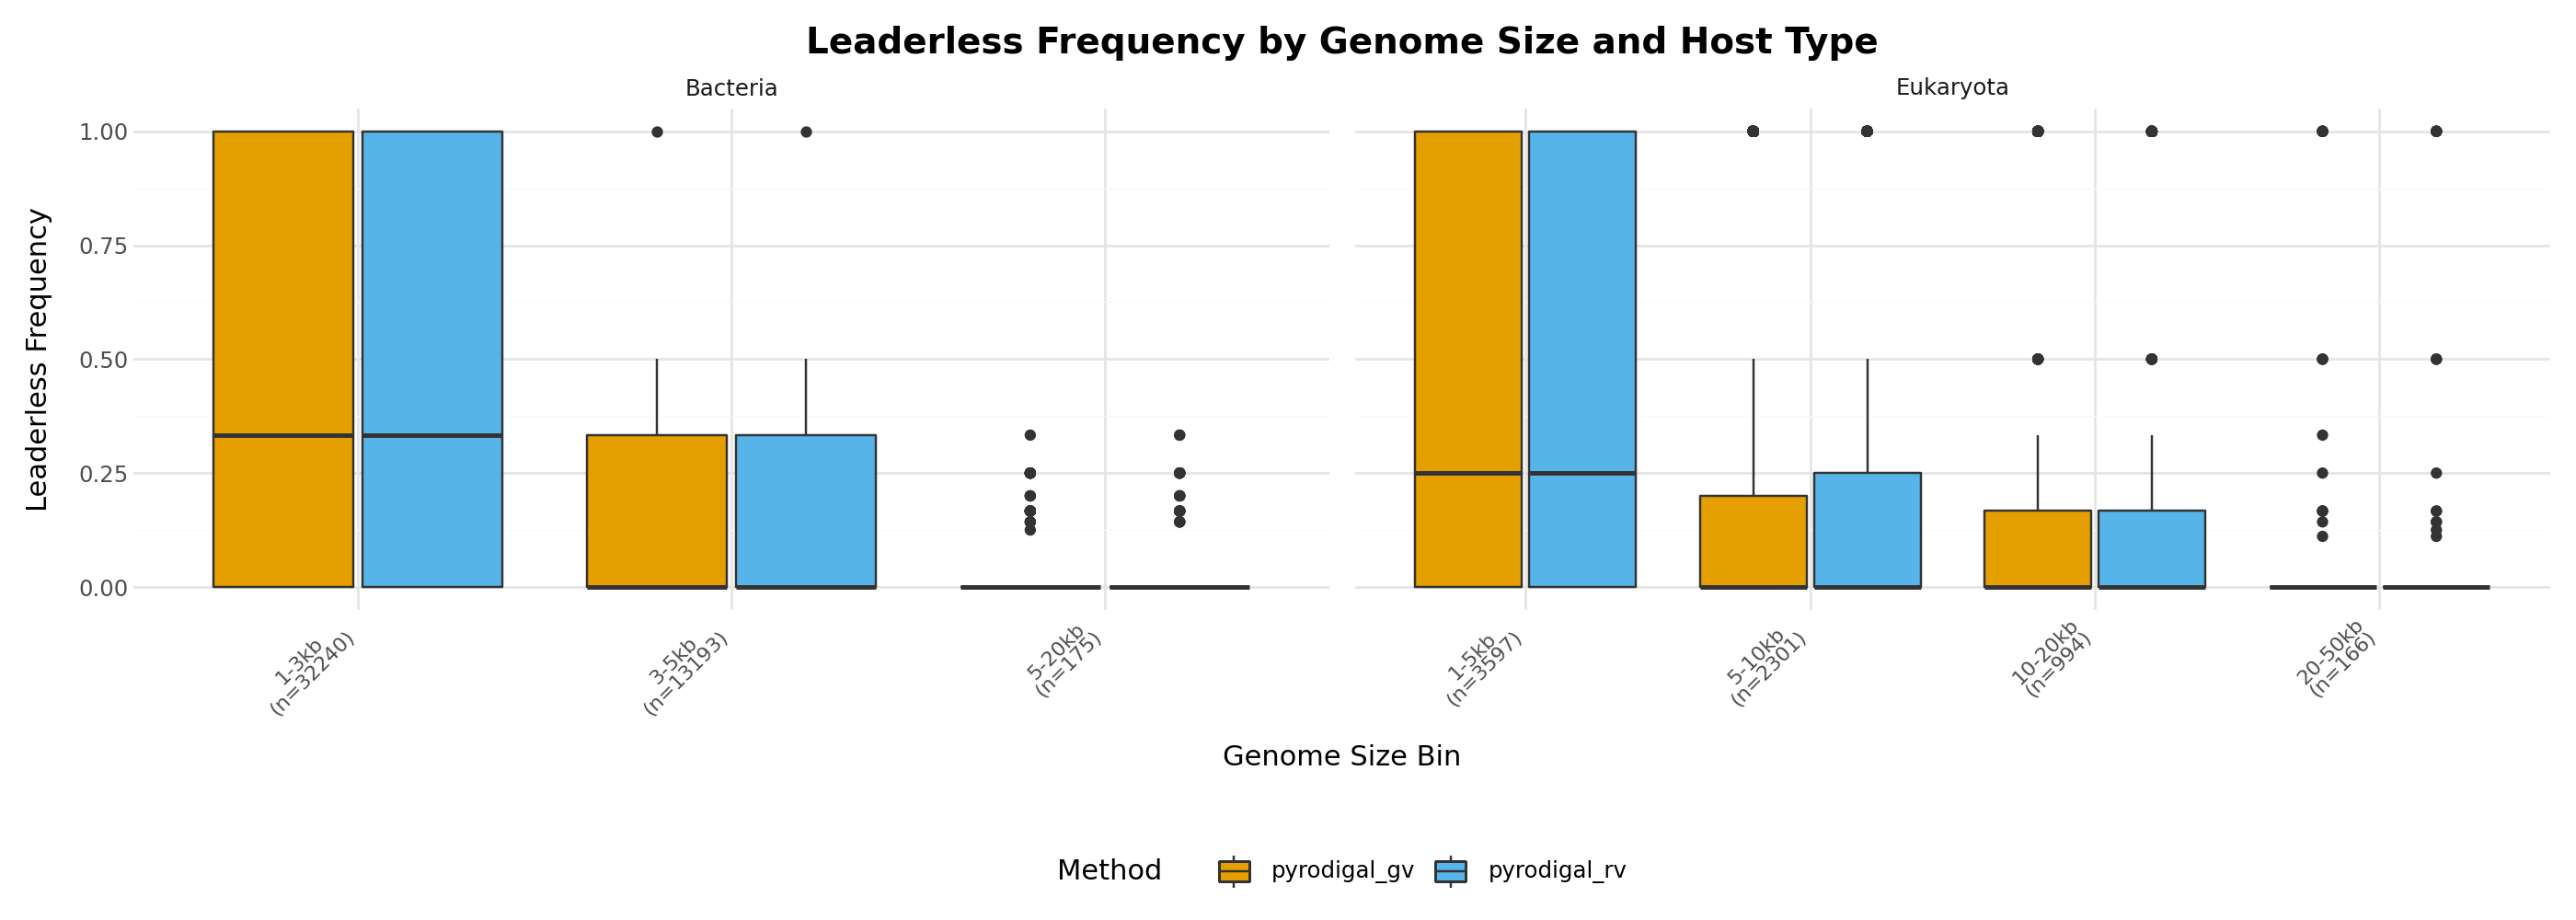


Leaderless Frequency - Summary Statistics by Host and Method:


Bacteria:
  pyrodigal_gv: mean=0.350, median=0.333
  pyrodigal_rv: mean=0.351, median=0.333
  Difference (GV - RV): -0.001

Eukaryota:
  pyrodigal_gv: mean=0.283, median=0.000
  pyrodigal_rv: mean=0.287, median=0.000
  Difference (GV - RV): -0.004

Comparing: Short UTR Frequency


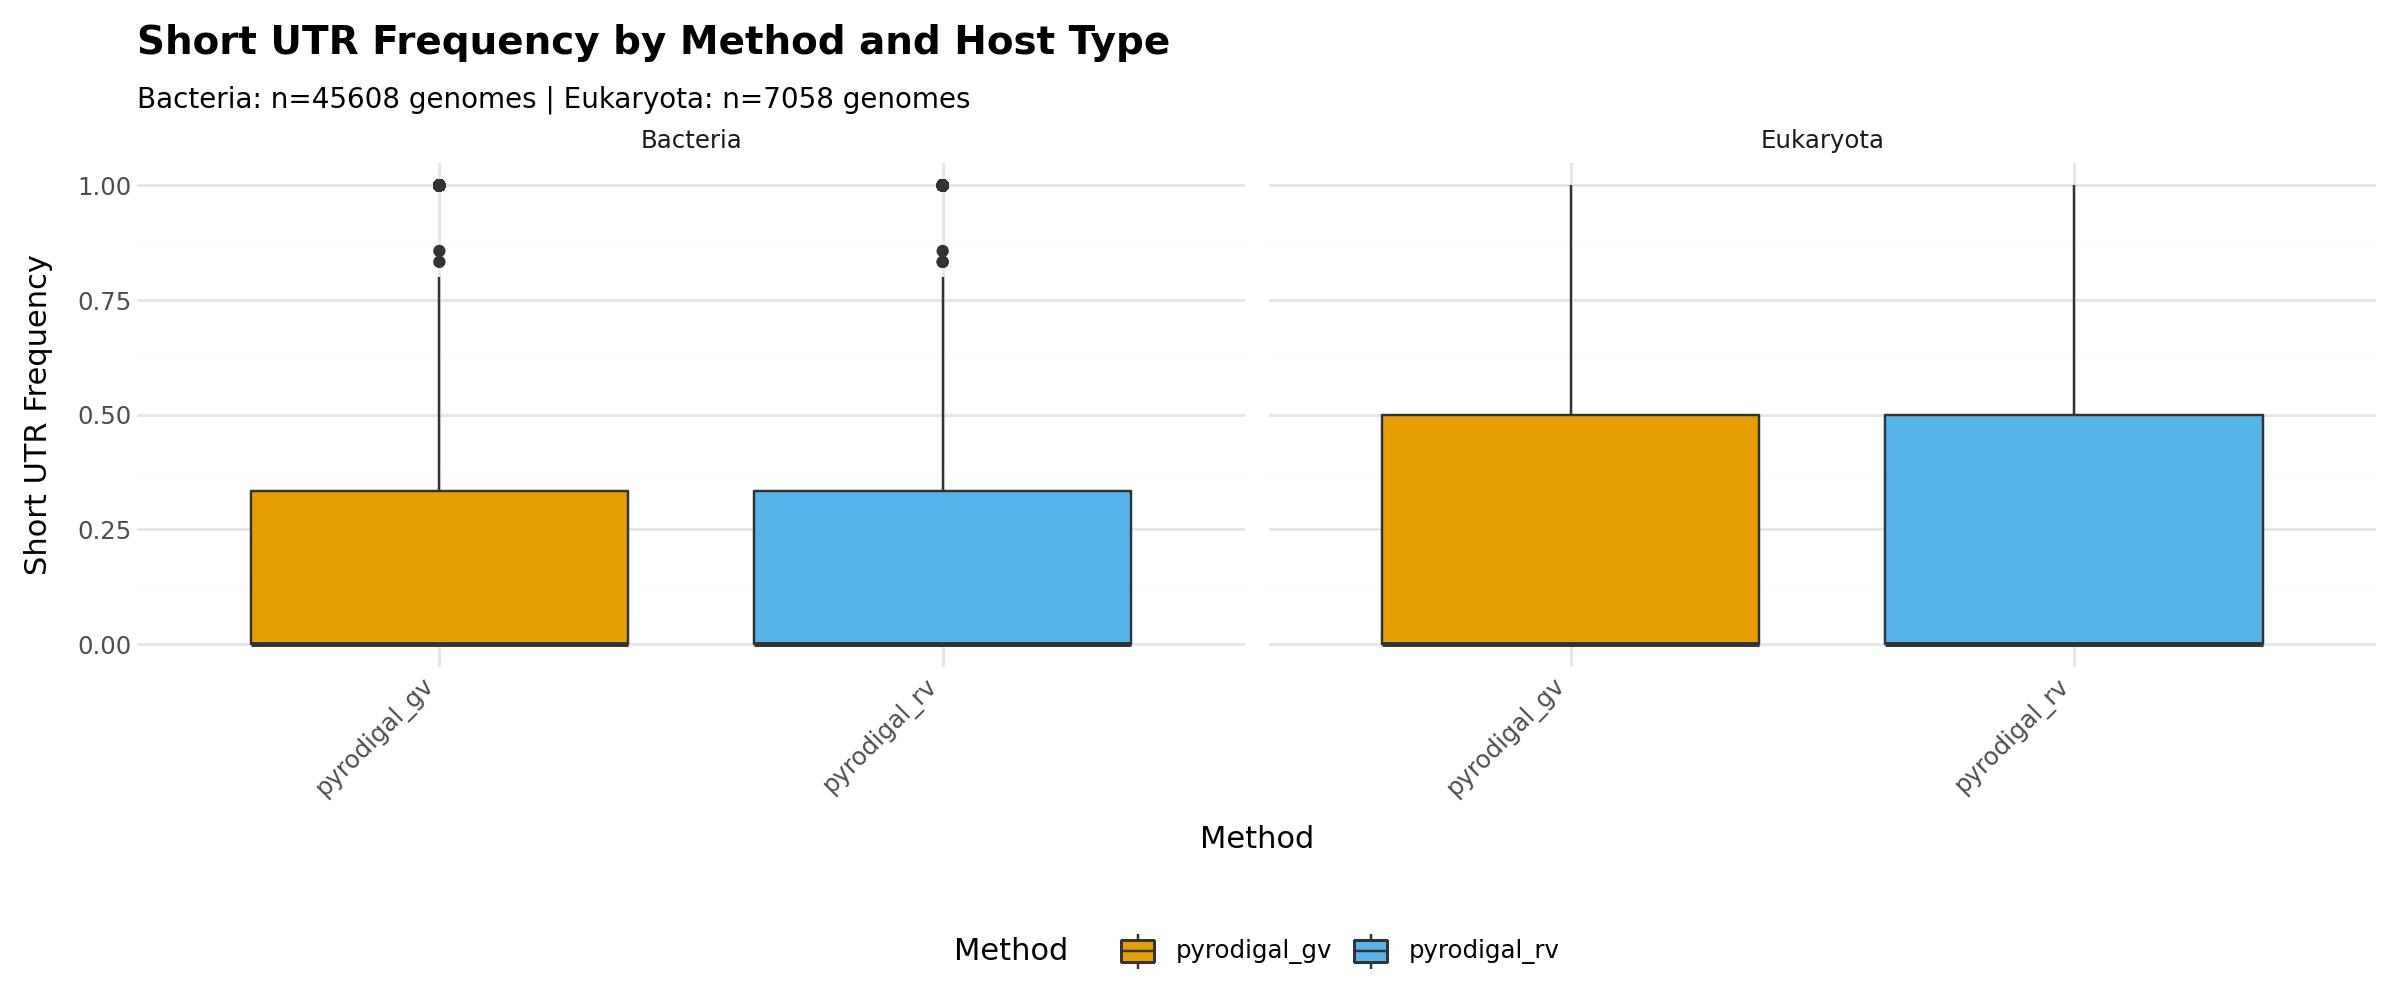

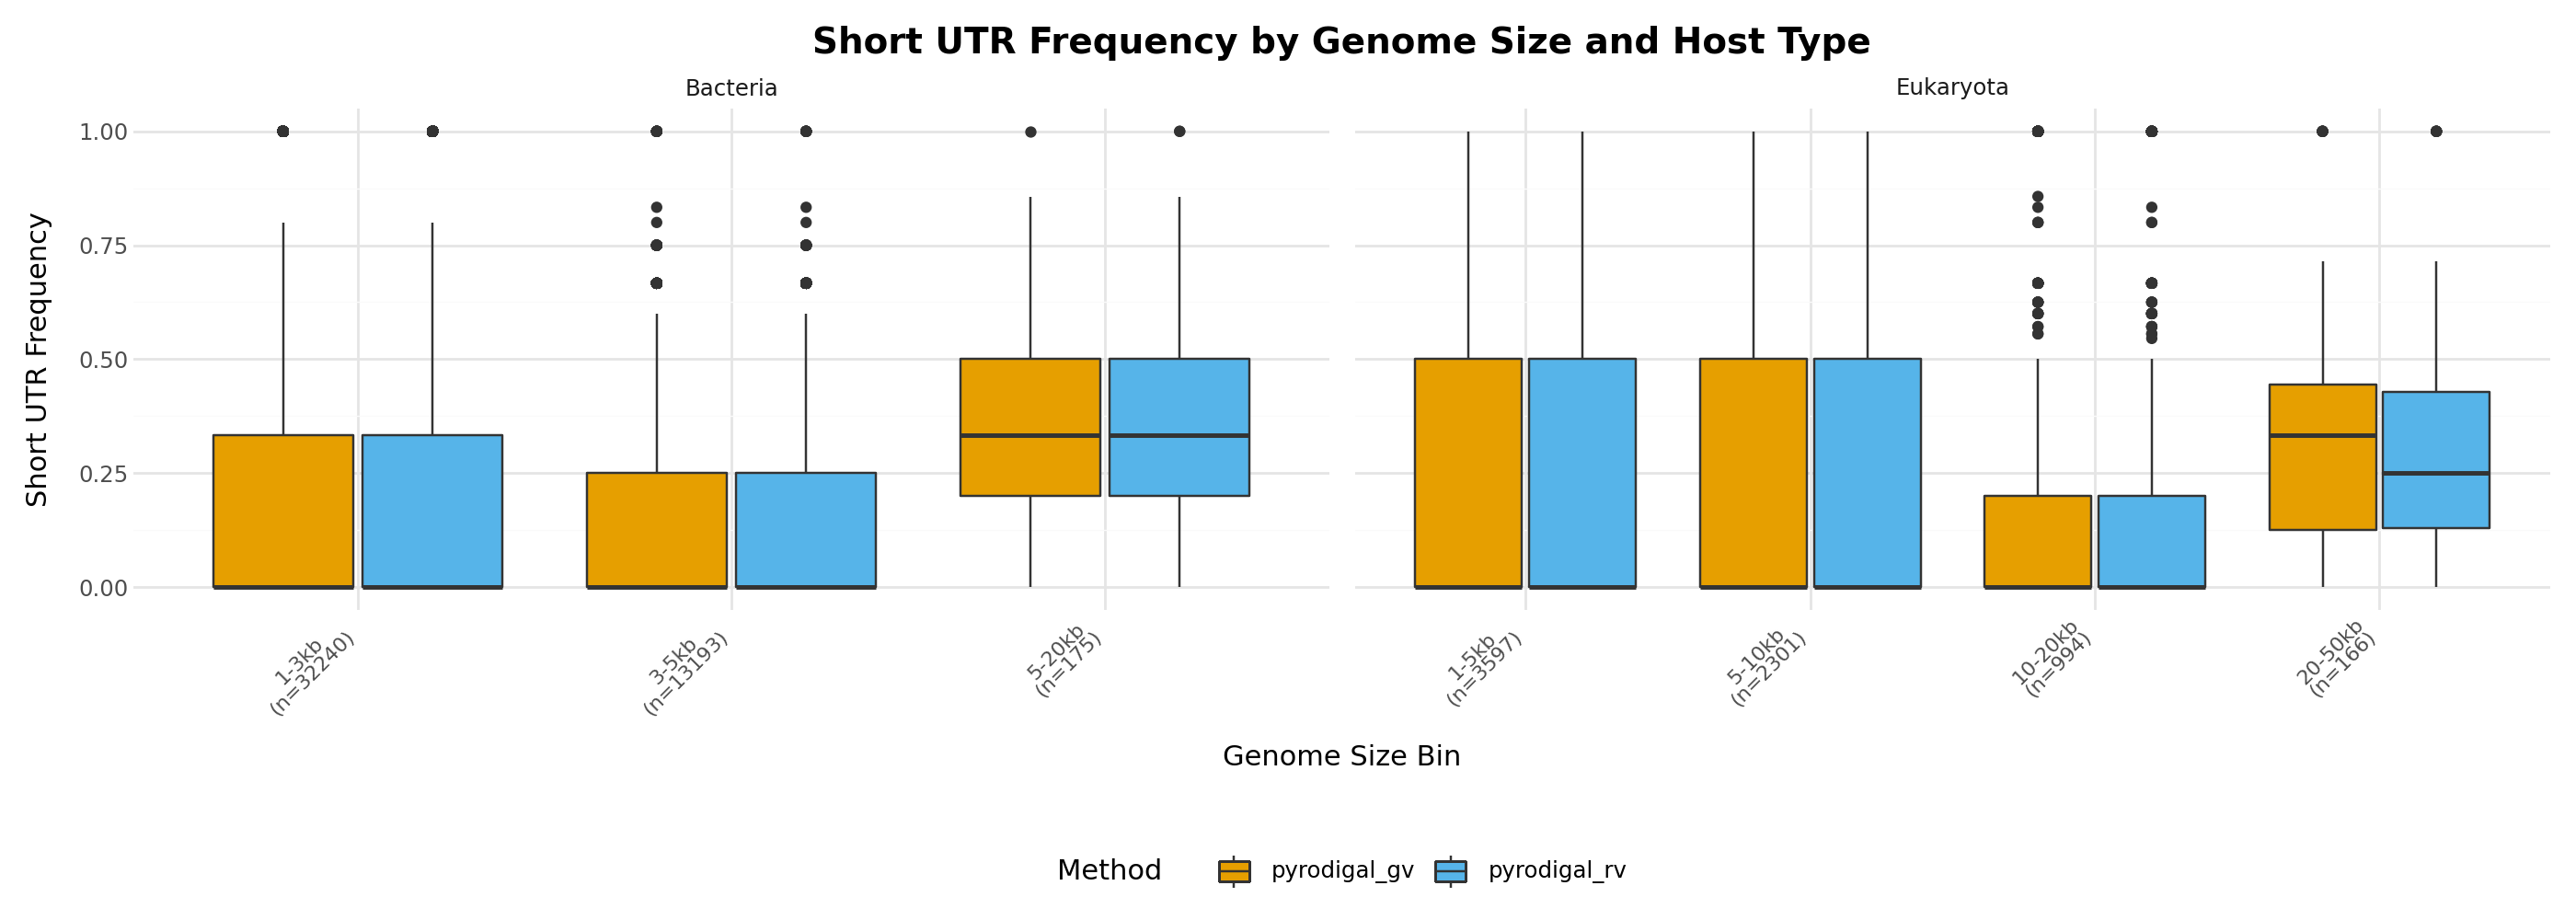


Short UTR Frequency - Summary Statistics by Host and Method:


Bacteria:
  pyrodigal_gv: mean=0.178, median=0.000
  pyrodigal_rv: mean=0.179, median=0.000
  Difference (GV - RV): -0.001

Eukaryota:
  pyrodigal_gv: mean=0.229, median=0.000
  pyrodigal_rv: mean=0.233, median=0.000
  Difference (GV - RV): -0.004


In [6]:
# ------------------------------------------------------------------
# Comparison plots: pyrodigal_gv vs pyrodigal_rv using plotnine
# ------------------------------------------------------------------

# Define a colorblind-friendly palette
colors = ['#E69F00', '#56B4E9']  # Orange for gv, Sky Blue for rv

def plot_method_comparison(data_pl, metric, ylabel=None):
    """Plot a metric comparing pyrodigal_gv vs pyrodigal_rv, separated by host type."""
    if ylabel is None:
        ylabel = metric
    
    # Add size bins - different for bacteria and eukaryotes
    data_pl = data_pl.with_columns([
        pl.when(pl.col('host') == 'Bacteria')
        .then(
            pl.when(pl.col('seq_len_kb') <= 3).then(pl.lit('1-3kb'))
            .when(pl.col('seq_len_kb') <= 5).then(pl.lit('3-5kb'))
            .when(pl.col('seq_len_kb') <= 20).then(pl.lit('5-20kb'))
            .otherwise(pl.lit('>20kb'))
        )
        .otherwise(
            pl.when(pl.col('seq_len_kb') <= 5).then(pl.lit('1-5kb'))
            .when(pl.col('seq_len_kb') <= 10).then(pl.lit('5-10kb'))
            .when(pl.col('seq_len_kb') <= 20).then(pl.lit('10-20kb'))
            .when(pl.col('seq_len_kb') <= 50).then(pl.lit('20-50kb'))
            .otherwise(pl.lit('>50kb'))
        )
        .alias('size_bin')
    ])
    
    # Calculate sample sizes for labeling
    n_bacteria = data_pl.filter(
        (pl.col('host') == 'Bacteria') & (pl.col('method') == 'pyrodigal_gv')
    ).height
    n_eukaryota = data_pl.filter(
        (pl.col('host') == 'Eukaryota') & (pl.col('method') == 'pyrodigal_gv')
    ).height
    
    # ------------------------------------------------------------------
    # Overall comparison plot
    # ------------------------------------------------------------------
    overall_plot = (
        ggplot(data_pl, aes(x='method', y=metric, fill='method')) +
        geom_boxplot() +
        facet_wrap('~host', scales='free_x') +
        labs(
            title=f'{ylabel} by Method and Host Type',
            subtitle=f'Bacteria: n={n_bacteria} genomes | Eukaryota: n={n_eukaryota} genomes',
            x='Method',
            y=ylabel,
            fill='Method'
        ) +
        scale_fill_manual(values=colors) +
        theme_minimal() +
        theme(
            plot_title=element_text(size=14, weight='bold'),
            plot_subtitle=element_text(size=10),
            axis_text_x=element_text(angle=45, hjust=1),
            legend_position='bottom',
            figure_size=(12, 5)
        )
    )
    
    overall_plot.show()
    
    # ------------------------------------------------------------------
    # By genome size plot with sample counts
    # ------------------------------------------------------------------
    # Define size bin order for each host type
    bacteria_size_order = ['1-3kb', '3-5kb', '5-20kb', '>20kb']
    eukaryota_size_order = ['1-5kb', '5-10kb', '10-20kb', '20-50kb', '>50kb']
    
    # Calculate sample counts per size bin per host (using pyrodigal_gv counts)
    size_counts = (
        data_pl.filter(pl.col('method') == 'pyrodigal_gv')
        .group_by(['host', 'size_bin'])
        .agg(pl.len().alias('n'))
    )
    
    # Add size_bin_label column with counts
    def get_label(host, size_bin):
        count_row = size_counts.filter(
            (pl.col('host') == host) & (pl.col('size_bin') == size_bin)
        )
        if count_row.height > 0:
            count = count_row['n'].item()
            return f"{size_bin}\n(n={count})"
        return size_bin
    
    # Create labeled version
    data_with_labels = data_pl.with_columns(
        pl.struct(['host', 'size_bin']).map_elements(
            lambda x: get_label(x['host'], x['size_bin']),
            return_dtype=pl.Utf8
        ).alias('size_bin_label')
    )
    
    # Convert to pandas and set categorical order per host
    data_pd = data_with_labels.to_pandas()
    
    # Create ordered categories - bacteria labels first, then eukaryota labels
    bacteria_labels = [get_label('Bacteria', sb) for sb in bacteria_size_order 
                      if get_label('Bacteria', sb) in data_pd['size_bin_label'].values]
    eukaryota_labels = [get_label('Eukaryota', sb) for sb in eukaryota_size_order
                       if get_label('Eukaryota', sb) in data_pd['size_bin_label'].values]
    
    all_ordered_labels = bacteria_labels + eukaryota_labels
    data_pd['size_bin_label'] = pd.Categorical(
        data_pd['size_bin_label'],
        categories=all_ordered_labels,
        ordered=True
    )
    
    size_plot = (
        ggplot(data_pd, aes(x='size_bin_label', y=metric, fill='method')) +
        geom_boxplot(position=position_dodge(width=0.8)) +
        facet_wrap('~host', scales='free_x') +
        labs(
            title=f'{ylabel} by Genome Size and Host Type',
            x='Genome Size Bin',
            y=ylabel,
            fill='Method'
        ) +
        scale_fill_manual(values=colors) +
        theme_minimal() +
        theme(
            plot_title=element_text(size=14, weight='bold'),
            axis_text_x=element_text(angle=45, hjust=1, size=8),
            legend_position='bottom',
            figure_size=(14, 5)
        )
    )
    
    size_plot.show()

    # ------------------------------------------------------------------
    # Print summary statistics
    # ------------------------------------------------------------------
    print(f"\n{ylabel} - Summary Statistics by Host and Method:")
    print("\n" + "="*60)
    
    for host in ['Bacteria', 'Eukaryota']:
        print(f"\n{host}:")
        host_data = data_pl.filter(pl.col('host') == host)
        
        for method in ['pyrodigal_gv', 'pyrodigal_rv']:
            method_data = host_data.filter(pl.col('method') == method)
            if method_data.height > 0:
                mean_val = method_data.select(pl.col(metric).mean()).item()
                median_val = method_data.select(pl.col(metric).median()).item()
                print(f"  {method}: mean={mean_val:.3f}, median={median_val:.3f}")
        
        # Calculate difference
        gv_data = host_data.filter(pl.col('method') == 'pyrodigal_gv')
        rv_data = host_data.filter(pl.col('method') == 'pyrodigal_rv')
        if gv_data.height > 0 and rv_data.height > 0:
            gv_mean = gv_data.select(pl.col(metric).mean()).item()
            rv_mean = rv_data.select(pl.col(metric).mean()).item()
            diff = gv_mean - rv_mean
            print(f"  Difference (GV - RV): {diff:.3f}")

# Plot comparisons for all key metrics
metrics = [
    ('coding_density', 'Coding Density'),
    ('no_rbs_freq', 'No RBS Frequency'),
    ('sd_bacteroidetes_rbs_freq', 'Bacteroidetes RBS Frequency'),
    ('sd_canonical_rbs_freq', 'Canonical SD RBS Frequency'),
    ('tatata_rbs_freq', 'TATATA RBS Frequency'),
    ('mean_rbs_score', 'Mean RBS Score'),
    ('gene_density', 'Gene Density (genes/kb)'),
    ('leaderless_freq', 'Leaderless Frequency'),
    ('short_utr_freq', 'Short UTR Frequency'),
]

print("\n" + "="*60)
print("pyrodigal_gv vs pyrodigal_rv Method Comparison")
print("="*60)

for metric, ylabel in metrics:
    print(f"\n{'='*60}")
    print(f"Comparing: {ylabel}")
    print('='*60)
    plot_method_comparison(df_all_combined, metric, ylabel)


In comparison to pyrodigal-gv, pyrodigal-rv has fewer ribosomal binding sites detected in eukaryotic RNA viruses (with only a small decrease in those detected in prokaryotic RNA viruses)